### DS-GA 1015 Final Project

#### Haonan Tian 

#### ht1151

In [69]:
## Initialization 
import _pickle as cPickle
import treeUtil
import os

import string 
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import collections
from collections import Counter
from lexicalrichness import LexicalRichness
import lexicalrichness

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import gensim.corpora as corpora
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

from gensim import corpora
import pickle
import gensim
from nltk import NaiveBayesClassifier, NaiveBayesDependencyScorer
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.python.framework import ops
#from tensorflow.contrib import rnn
from tensorflow.keras.layers import LSTMCell
from tensorflow.nn import rnn_cell, static_rnn
from tensorflow.nn.rnn_cell import BasicLSTMCell, BasicRNNCell

current_path = os.getcwd()
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#### Load data

In [2]:
# Load ICB sample data set
[lib, con, neutral] = cPickle.load(open(current_path + '/sample_ibc/sampleData.pkl', 'rb'))

lib_corpus = [tree.get_words() for tree in lib]
con_corpus = [tree.get_words() for tree in con]
neutral_corpus = [tree.get_words() for tree in neutral]
all_corpus = lib_corpus + con_corpus + neutral_corpus

In [3]:
# convote data set loading functions
stage_one_path = current_path + '/convote_v1.1/data_stage_one'
stage_two_path = current_path + '/convote_v1.1/data_stage_two'
stage_three_path = current_path + '/convote_v1.1/data_stage_three'

def load_convote_file_name(stage_path, set_name='training'):
    '''
        load file names in one directory to the program 
        for convote_v1.1 data set
        
        parameters:
        stage_path: the path to the stage file
        set_name: possible arguments are 'training', 'development' or 
            'test' so that the corresponding directory will be loaded
        return:
        file_name_list: a list of file names in the specified directory
        current_path: the path to the directory which contains all files
    '''
    current_path = ""
    if set_name == 'training':
        current_path = stage_path + '/training_set/'
    elif set_name == 'development':
        current_path = stage_path + '/development_set/'
    else:
        current_path = stage_path + '/test_set/'
        
    file_name_list = []
    for _, _, file_name in os.walk(current_path):
        file_name_list = file_name
    return file_name_list, current_path

def load_file_with_label(file_names, input_path, bill_loaded):
    '''
        function to load all files in the specified path to the program
        
        parameters:
        file_names: list of file names in the specified directory
        input_path: the path of the directory that all files are stored
        bill_loaded: a list of bill ids which has been loaded to the program
        return:
        bill_idx: a list of document id which have been loaded into the program
        document_list: the list that contained the contents of these files
        label_list: the list with all labels. We labeled 
            demoncrat as 1 and republican as 0.
    '''
    speech_id_list = []
    document_list = []
    label_list = []
    total_file_loaded = 0
    
    print('Start loading ...')
    for file_name in file_names:
        temp_name = file_name.lstrip().strip('.txt')
        name_token = temp_name.split('_')
        
        bill_idx = name_token[0]
        speaker_id = name_token[1]
        page_id = name_token[2]
        label = name_token[3][0]
            
        if label == "R":
            label_list.append(0)
        elif label == "D":
            label_list.append(1)
        else:
            continue
            
        speech_id = bill_idx + '_' + speaker_id + '_' + page_id
        if speech_id not in speech_id_list and speech_id not in bill_loaded:
            speech_id_list.append(speech_id)
        else:
            continue
        
        with open(input_path + file_name) as content_file:
            document_list.append(content_file.read())
            total_file_loaded += 1
            if total_file_loaded % 200 == 0:
                print('{} files have been loaded'.format(total_file_loaded))
    print('{} files loaded'.format(total_file_loaded))
    print('Finished loading ...')
    loaded_bills = speech_id_list + bill_loaded
    return loaded_bills, document_list, label_list

In [4]:
# load file name lists
s1_training_file_names, path_s1_train = load_convote_file_name(stage_one_path, set_name="training")
s1_develop_file_names, path_s1_develop = load_convote_file_name(stage_one_path, set_name="development")
s1_test_file_names, path_s1_test = load_convote_file_name(stage_one_path, set_name="test")

s2_training_file_names, path_s2_train = load_convote_file_name(stage_two_path, set_name="training")
s2_develop_file_names, path_s2_develop = load_convote_file_name(stage_two_path, set_name="development")
s2_test_file_names, path_s2_test = load_convote_file_name(stage_two_path, set_name="test")

s3_training_file_names, path_s3_train = load_convote_file_name(stage_three_path, set_name="training")
s3_develop_file_names, path_s3_develop = load_convote_file_name(stage_three_path, set_name="development")
s3_test_file_names, path_s3_test = load_convote_file_name(stage_three_path, set_name="test")

In [5]:
# load file contents
# will only use stage one since stage one data contains almost all files in stage two and three
s1_bills, s1_training_contents, s1_training_labels = load_file_with_label(s1_training_file_names, path_s1_train, [])
s1_bills, s1_develop_contents, s1_develop_labels = load_file_with_label(s1_develop_file_names, path_s1_develop, s1_bills)
s1_bills, s1_test_contents, s1_test_labels = load_file_with_label(s1_test_file_names, path_s1_test, s1_bills)

Start loading ...
200 files have been loaded
400 files have been loaded
600 files have been loaded
800 files have been loaded
1000 files have been loaded
1200 files have been loaded
1400 files have been loaded
1600 files have been loaded
1800 files have been loaded
2000 files have been loaded
2200 files have been loaded
2400 files have been loaded
2600 files have been loaded
2800 files have been loaded
3000 files have been loaded
3200 files have been loaded
3400 files have been loaded
3600 files have been loaded
3800 files have been loaded
4000 files have been loaded
4200 files have been loaded
4400 files have been loaded
4600 files have been loaded
4800 files have been loaded
5000 files have been loaded
5200 files have been loaded
5400 files have been loaded
5600 files have been loaded
5634 files loaded
Finished loading ...
Start loading ...
200 files have been loaded
400 files have been loaded
600 files have been loaded
702 files loaded
Finished loading ...
Start loading ...
200 file

#### Data exploration

In [11]:
# Calculate TTR
lexi_list = []
ttr_list = []
for doc in s1_training_contents:
    lexi = LexicalRichness(doc)
    lexi_list.append(lexi)
    ttr_list.append(lexi.ttr)

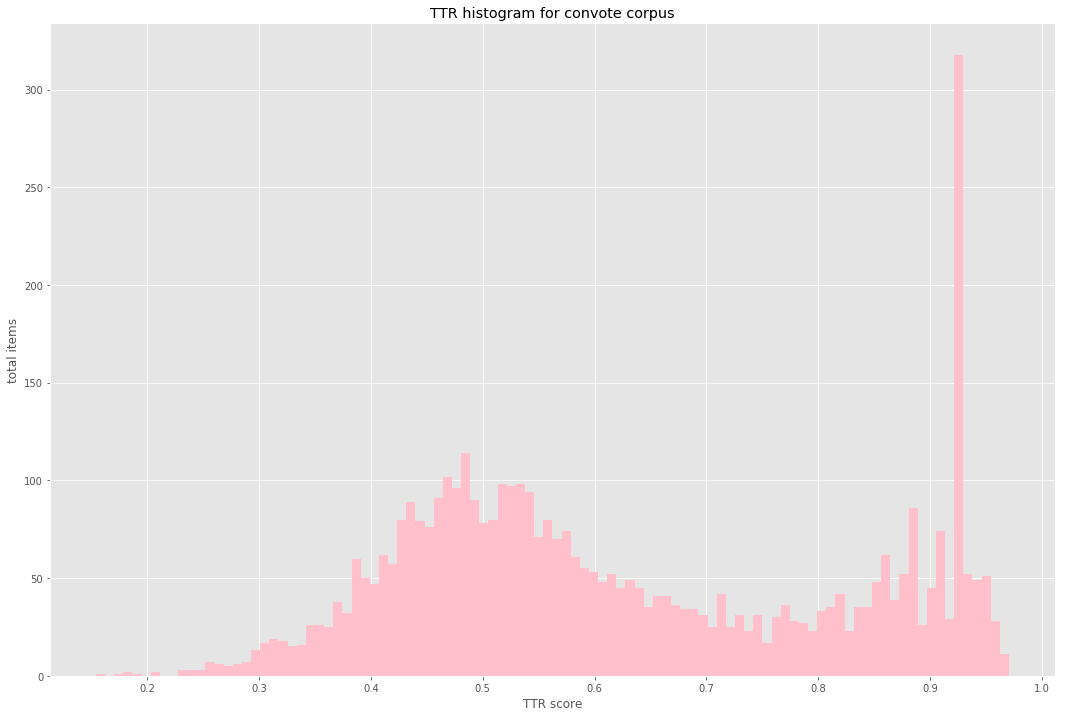

In [18]:
matplotlib.rcParams['figure.figsize'] = (18.0, 12.0)
matplotlib.style.use('ggplot')
bins_all = 100
ttr_lst = [i for i in ttr_list if i != 1]
n, _, _ = plt.hist(x=ttr_lst, bins=bins_all, color='pink', rwidth=1.0)
plt.title('TTR histogram for convote corpus')
plt.xlabel('TTR score')
plt.ylabel('total items')
plt.show()

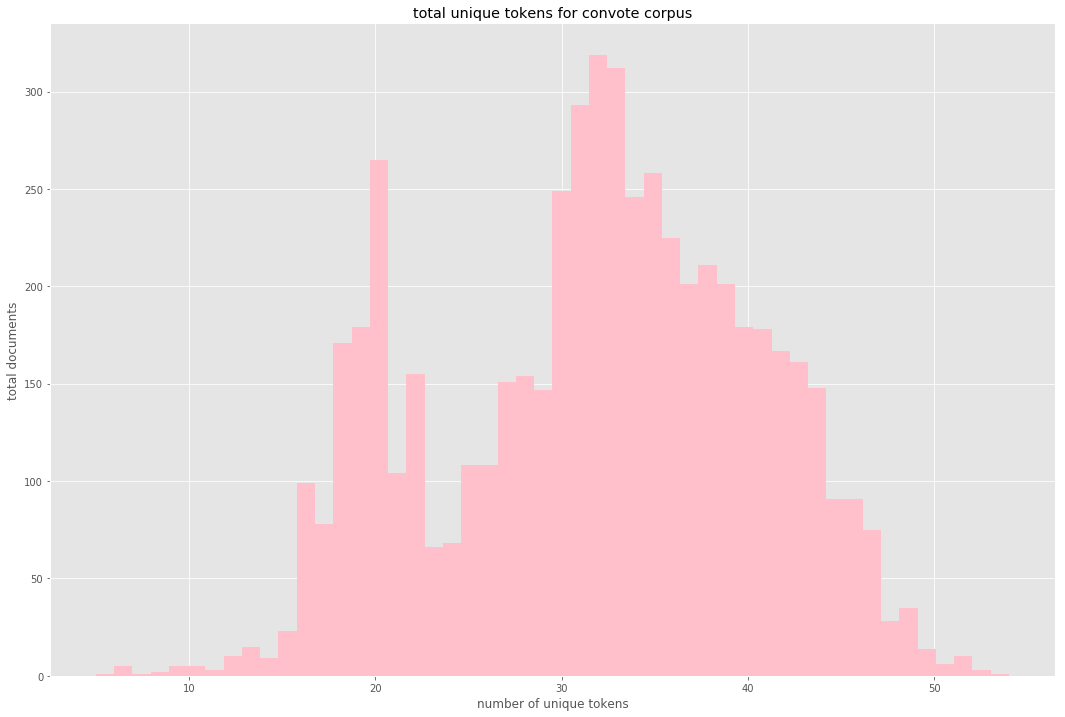

In [20]:
# calculate total number of unique tokens for each document
unique_tok = []
for doc in s1_training_contents:
    total = len(Counter(doc))
    unique_tok.append(total)

bins_all = 50
n, _, _ = plt.hist(x=unique_tok, bins=bins_all, color='pink', rwidth=1.0)
plt.title('total unique tokens for convote corpus')
plt.xlabel('number of unique tokens')
plt.ylabel('total documents')
plt.show()

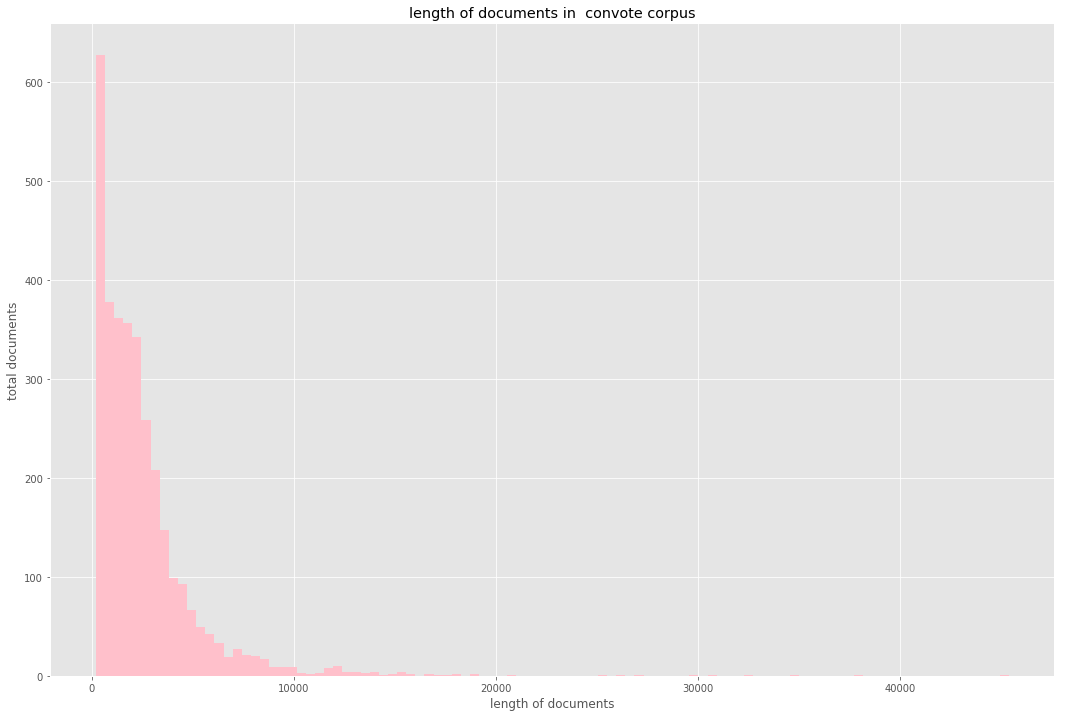

In [23]:
# Calculate the length of documents in the corpus
len_lis = [len(i) for i in s1_training_contents if len(i) > 200]

bins_all = 100
n, _, _ = plt.hist(x=len_lis, bins=bins_all, color='pink', rwidth=1.0)
plt.title('length of documents in  convote corpus')
plt.xlabel('length of documents')
plt.ylabel('total documents')
plt.show()

#### Data preprocessing

In [28]:
# Basic text proprocessing functions
def convert_to_token(input_str):
    '''
        convert an input string to a list of tokens splitted by white space
        all characters in the string are coverted to lower cases
        
        parameters:
        input_str: an input string (may be a document)
        return:
        token_list: a list of tokens splitted from string by white space
    '''
    token_list = input_str.lower().lstrip().strip().split(' ')
    return token_list

def remove_punctuation(input_tokens):
    '''
        remove punctuation from a input list of tokens 
        
        parameters:
        input_tokens: a list of tokens including punctuations
        return:
        result: a list of tokens with punctuations removed
    ''' 
    punct_table = str.maketrans('', "", string.punctuation)
    stripped = [tok.translate(punct_table) for tok in input_tokens]
    result = [i for i in stripped if i != '']
    return result

def token_stem(input_tokens):
    '''
        apply the Porter Stemmer in nltk to stem all tokens in the input token list
        
        parameters:
        input_tokens: a list of tokens
        return:
        result: a list of tokens with all tokens stemmed
    '''
    ps = PorterStemmer()
    result = [ps.stem(tok) for tok in input_tokens]
    return result

def remove_stopwords(input_tokens):
    '''
        remove stopwords and non-alphabetic characters from the token list
        
        parameters:
        input_tokens: a list of tokens
        return:
        result: a list of tokens with all non-alphabetic characters and stopwords removed
    '''
    temp = [tok for tok in input_tokens if tok.isalpha()]
    stop_words = set(stopwords.words('english'))
    result = [tok for tok in temp if not tok in stop_words]
    return result

def preprocess_text(input_corpus):
    '''
        wrap up function to include all of the above preprocessing techniques
        
        parameters:
        input_corpus: a list if documents with each document represented as a string
        return:
        result: a list of documents with each document represented as a list of preprocessed tokens
    '''
    result = []
    for doc in input_corpus:
        tokenized_doc = convert_to_token(doc)
        cleaned_doc = remove_punctuation(tokenized_doc)
        stemmed_doc = token_stem(cleaned_doc)
        temp_result = remove_stopwords(stemmed_doc)
        result.append(temp_result)
    return result

In [29]:
# Make dictionary
def find_all_tokens(input_corpus):
    '''
        find all tokens in a input corpus
        
        parameters:
        input_corpus: input corpus represented as a list of documents 
            with each document represented as a list of tokens
        return:
        all_tokens: a list of all tokens with duplications
    '''
    all_tokens = []
    counter = 0
    print('Start finding all tokens')
    
    for doc in input_corpus:
        all_tokens += doc
        if counter % 200 == 0:
            print('Finished loading {} documents'.format(counter))
        counter += 1
    
    print('{} documents parsed'.format(counter))
    print('Done')
    return all_tokens
        
def make_n_gram(input_corpus, N):
    '''
        function to establish a n-gram corpus based on the input corpus
        
        parameters:
        input_corpus: a list of documents with each one represented 
            in a list of single token
        N: argument to set n-gram
        return:
        result: a list if document with each one represented as a list of
            n-gram tokens
    '''
    result = []
    counter = 0
    print('Start making n-gram')
    
    for doc in input_corpus:
        temp_token = []
        for idx in range(len(doc)-N+1):
            temp = ''
            for i in range(idx, idx + N):
                temp += doc[i] 
                temp += ' '
            temp.strip(' ')
            temp_token.append(temp)
        result.append(temp_token)
        
        if counter % 200 == 0:
            print('Finished loading {} documents'.format(counter))
        counter += 1
    print('{} documents parsed'.format(counter))
    print('Done')
    return result
    
def build_vocab(all_tokens, max_vocab=20000, min_term_fre=30):
    '''
        set up the look up table for corpus
        
        parameters:
        all_tokens: a list which contains all tokens with duplication
        max_vocab: set the maximum vocabulary size
        min_term_fre: set the minimum term frequency
        return:
        id2tokens: a list with each index corresponds to an token
        tokens2id: a dictionary with each token corresponding to an index
    '''
    token_counter = Counter(all_tokens)
    tokens, frequency = zip(*token_counter.most_common(max_vocab))
    id2tokens = list(tokens)
    freq_list = list(frequency)
    freq_list = [i for i in freq_list if i > min_term_fre]
    id2tokens = id2tokens[:len(freq_list)]
    tokens2id = dict(zip(id2tokens, range(2,2+len(id2tokens))))
    tokens2id['<pad>'] = 0
    tokens2id['<unk>'] = 1
    return id2tokens, tokens2id

def convert_token_idx(input_corpus, tokens2id):
    '''
        convert corpus represented in token lists to numeric lists
        
        parameters:
        input_corpus: a list of documents represented in token lists
        tokens2id: the dictionary with the key as tokens and values 
            are the index of the corresponding tokens
        return:
        result: the corpus list in numeric format
    '''
    result = []
    counter = 0
    print('Start building numeric corpus')
    
    for doc in input_corpus:
        temp_list = []
        temp_list = [tokens2id[tok] if tok in tokens2id else tokens2id['<unk>'] for tok in doc]
        result.append(temp_list)
        counter += 1
        if counter % 200 == 0:
            print('Finished convertting {} documents'.format(counter))
            
    print('{} documents parsed'.format(counter))
    print('Done')
    return result

def convert_sparse_matrix(input_corpus, id2tokens):
    '''
        convert the input corpus which is in token format 
        to a sparse document matrix
        
        parameters:
        input_corpus: the input corpus which is represented in token format
        id2tokens: look up table to match the token with indices
        return:
        result: the sparse document matrix with entries equal to the frequencies
    '''
    result = []
    counter = 0
    print('Start building sparse document matrix')
    
    for doc in input_corpus:
        token_counter = Counter(doc)
        temp_vec = dict(zip(id2tokens, [0 for i in range(len(id2tokens))]))
        for tok in id2tokens:
            if tok in token_counter:
                temp_vec[tok] = token_counter[tok]
        temp = list(temp_vec.values())
        result.append(temp)
        if counter % 200 == 0:
            print('Finished {} documents'.format(counter))
        counter += 1
    
    print('{} documents parsed'.format(counter))
    print('Done')
    return result

In [30]:
# perform data preprocessing on icb data
lib_corpus = preprocess_text(lib_corpus)
con_corpus = preprocess_text(con_corpus)
neutral_corpus = preprocess_text(neutral_corpus)

In [31]:
# perform data preprocessing on convote data
train_convote = preprocess_text(s1_training_contents)
develop_convote = preprocess_text(s1_develop_contents)
test_convote = preprocess_text(s1_test_contents)

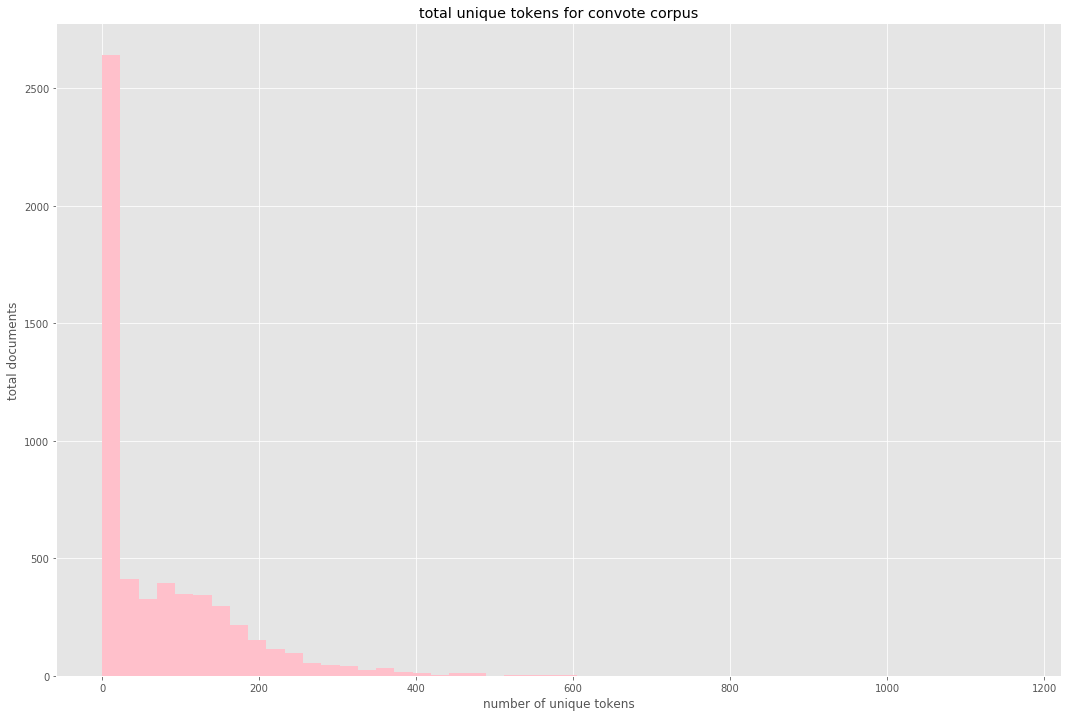

In [33]:
# calculate total number of unique tokens for each document
unique_tok = []
for doc in train_convote:
    total = len(Counter(doc))
    unique_tok.append(total)

bins_all = 50
n, _, _ = plt.hist(x=unique_tok, bins=bins_all, color='pink', rwidth=1.0)
plt.title('total unique tokens for convote corpus')
plt.xlabel('number of unique tokens')
plt.ylabel('total documents')
plt.show()

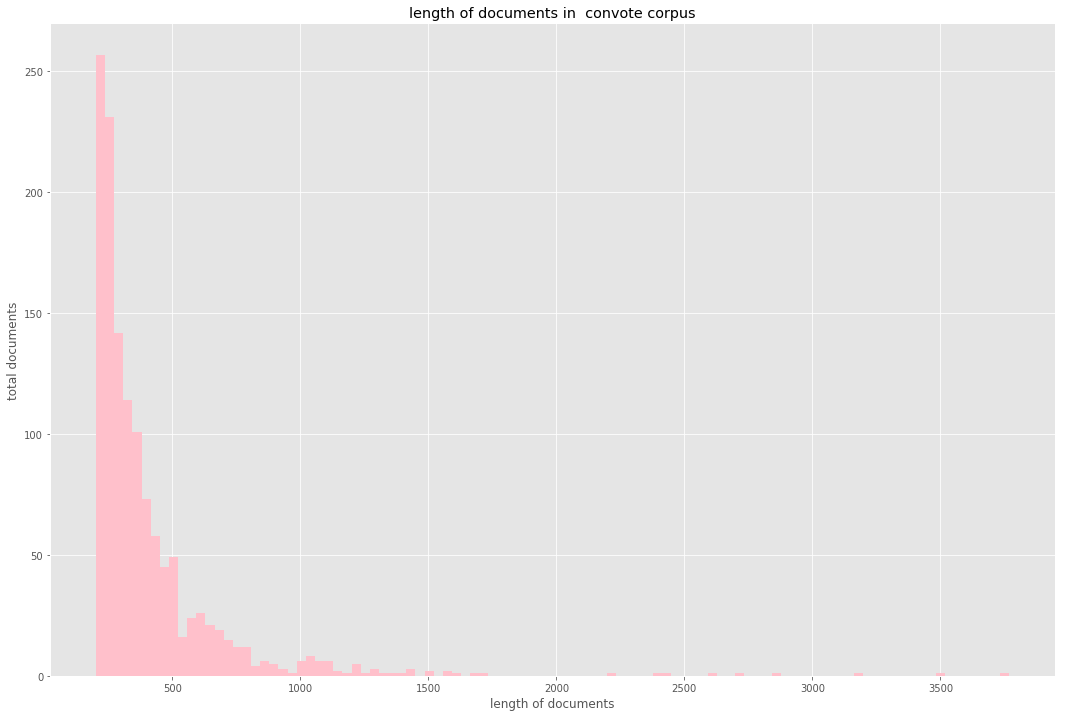

In [35]:
# Calculate length of documents in the corpus
len_lis = [len(i) for i in train_convote if len(i) > 200]

bins_all = 100
n, _, _ = plt.hist(x=len_lis, bins=bins_all, color='pink', rwidth=1.0)
plt.title('length of documents in  convote corpus')
plt.xlabel('length of documents')
plt.ylabel('total documents')
plt.show()

In [87]:
np.mean(len_lis)

407.4242658423493

#### Perform LDA 

In [50]:
def perform_convert(input_corpus, bench_mark_corpus):
    '''
        convert a token list to a numeric list
        
        parameters:
        input_corpus: input corpus represented as a list of tokens
        bench_mark_corpus: the bench mark corpus to biuild dictionary
        return:
        corpus: converted numeric document matrix
    '''
    dictionary = corpora.Dictionary(bench_mark_corpus)
    corpus = [dictionary.doc2bow(text) for text in input_corpus]
    return corpus

def perform_lda(input_corpus, num_topic=6, num_pass=10, num_word=5, write=False):
    '''
        perform topic modeling with lda algorithm 
        extract the abstract topics from corpus with speficied number of topics 
        
        parameters:
        input_corpus: the input corpus to train on 
        num_topic: the number of topic to generated from the specified corpus
        num_pass: the number of passes through the whole corpus
        num_word: the number of tokens to print out when checking the 
            top tokens related to a certain topic
        write: the parameter if set true, will write the generated dictionaries 
            and the trained lda model
        return:
        ldamodel: a lda model trained with given settings 
    '''
    dictionary = corpora.Dictionary(input_corpus)
    corpus = [dictionary.doc2bow(text) for text in input_corpus]
        
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = num_topic, 
                                               id2word=dictionary, passes=num_pass)
    if write:
        pickle.dump(corpus, open('corpus.pkl', 'wb'))
        dictionary.save('dictionary.gensim')
        ldamodel.save('lda_topic' + str(num_topic) + '.gensim')
    
    return ldamodel

In [53]:
# perform lda analysis on convote data
train_lib_convote = [train_convote[i] for i in range(len(s1_training_labels)) if s1_training_labels[i]==1]
train_con_convote = [train_convote[i] for i in range(len(s1_training_labels)) if s1_training_labels[i]==0]

lib_convote_lda = perform_lda(train_lib_convote)
con_convote_lda = perform_lda(train_con_convote)

In [55]:
# visualize the topics
for topic in lib_convote_lda.print_topics():
    print(topic)

(0, '0.012*"thi" + 0.010*"gun" + 0.010*"crime" + 0.010*"bill" + 0.009*"gang" + 0.008*"sentenc" + 0.008*"would" + 0.007*"wa" + 0.007*"feder" + 0.007*"law"')
(1, '0.037*"mr" + 0.024*"thi" + 0.023*"gentleman" + 0.019*"yield" + 0.018*"chairman" + 0.017*"speaker" + 0.015*"amend" + 0.012*"time" + 0.012*"would" + 0.011*"bill"')
(2, '0.013*"thi" + 0.013*"would" + 0.010*"hous" + 0.010*"gt" + 0.010*"lt" + 0.009*"bill" + 0.008*"law" + 0.007*"secur" + 0.007*"fund" + 0.007*"state"')
(3, '0.022*"thi" + 0.012*"bill" + 0.012*"cut" + 0.012*"budget" + 0.010*"fund" + 0.010*"program" + 0.009*"health" + 0.009*"million" + 0.009*"year" + 0.009*"billion"')
(4, '0.027*"thi" + 0.011*"bill" + 0.009*"would" + 0.009*"rule" + 0.008*"ha" + 0.008*"committe" + 0.008*"member" + 0.007*"hous" + 0.007*"us" + 0.007*"wa"')
(5, '0.019*"energi" + 0.016*"thi" + 0.014*"oil" + 0.012*"bill" + 0.009*"nation" + 0.008*"ga" + 0.008*"price" + 0.007*"us" + 0.006*"trade" + 0.006*"would"')


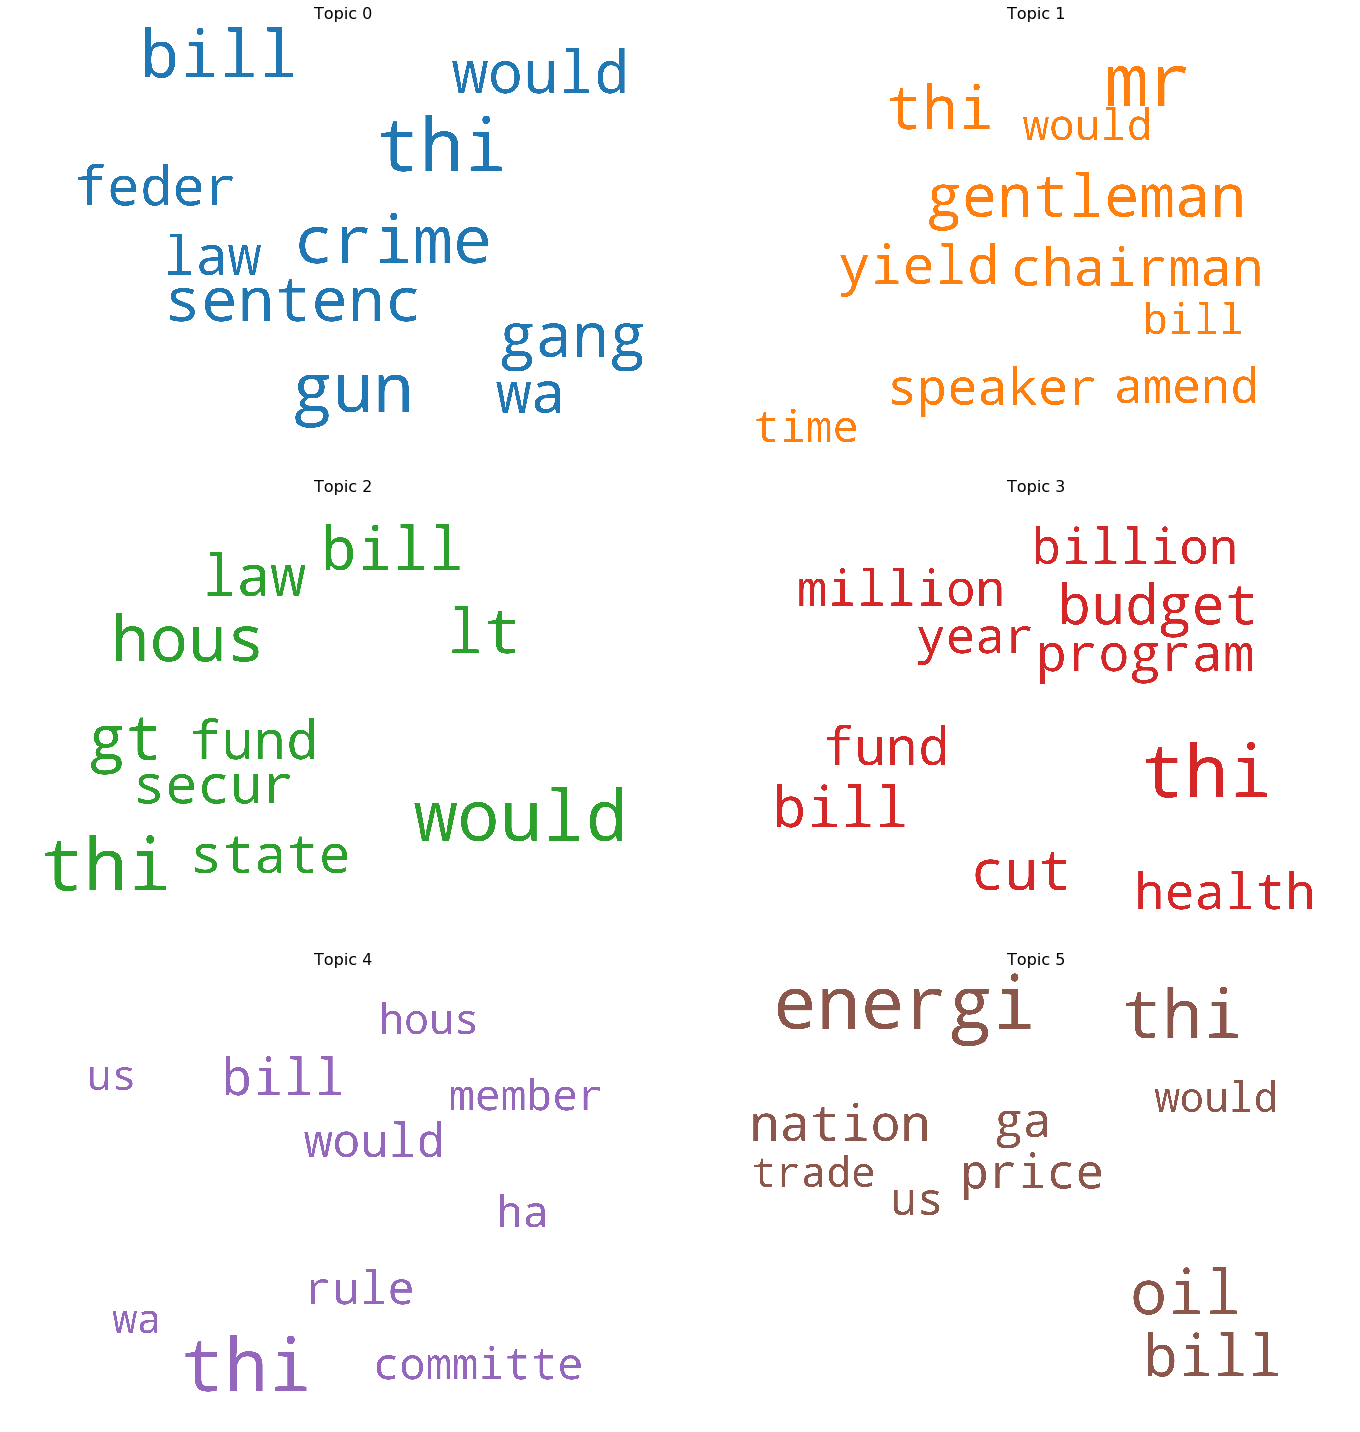

In [58]:
# visualization
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lib_convote_lda.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

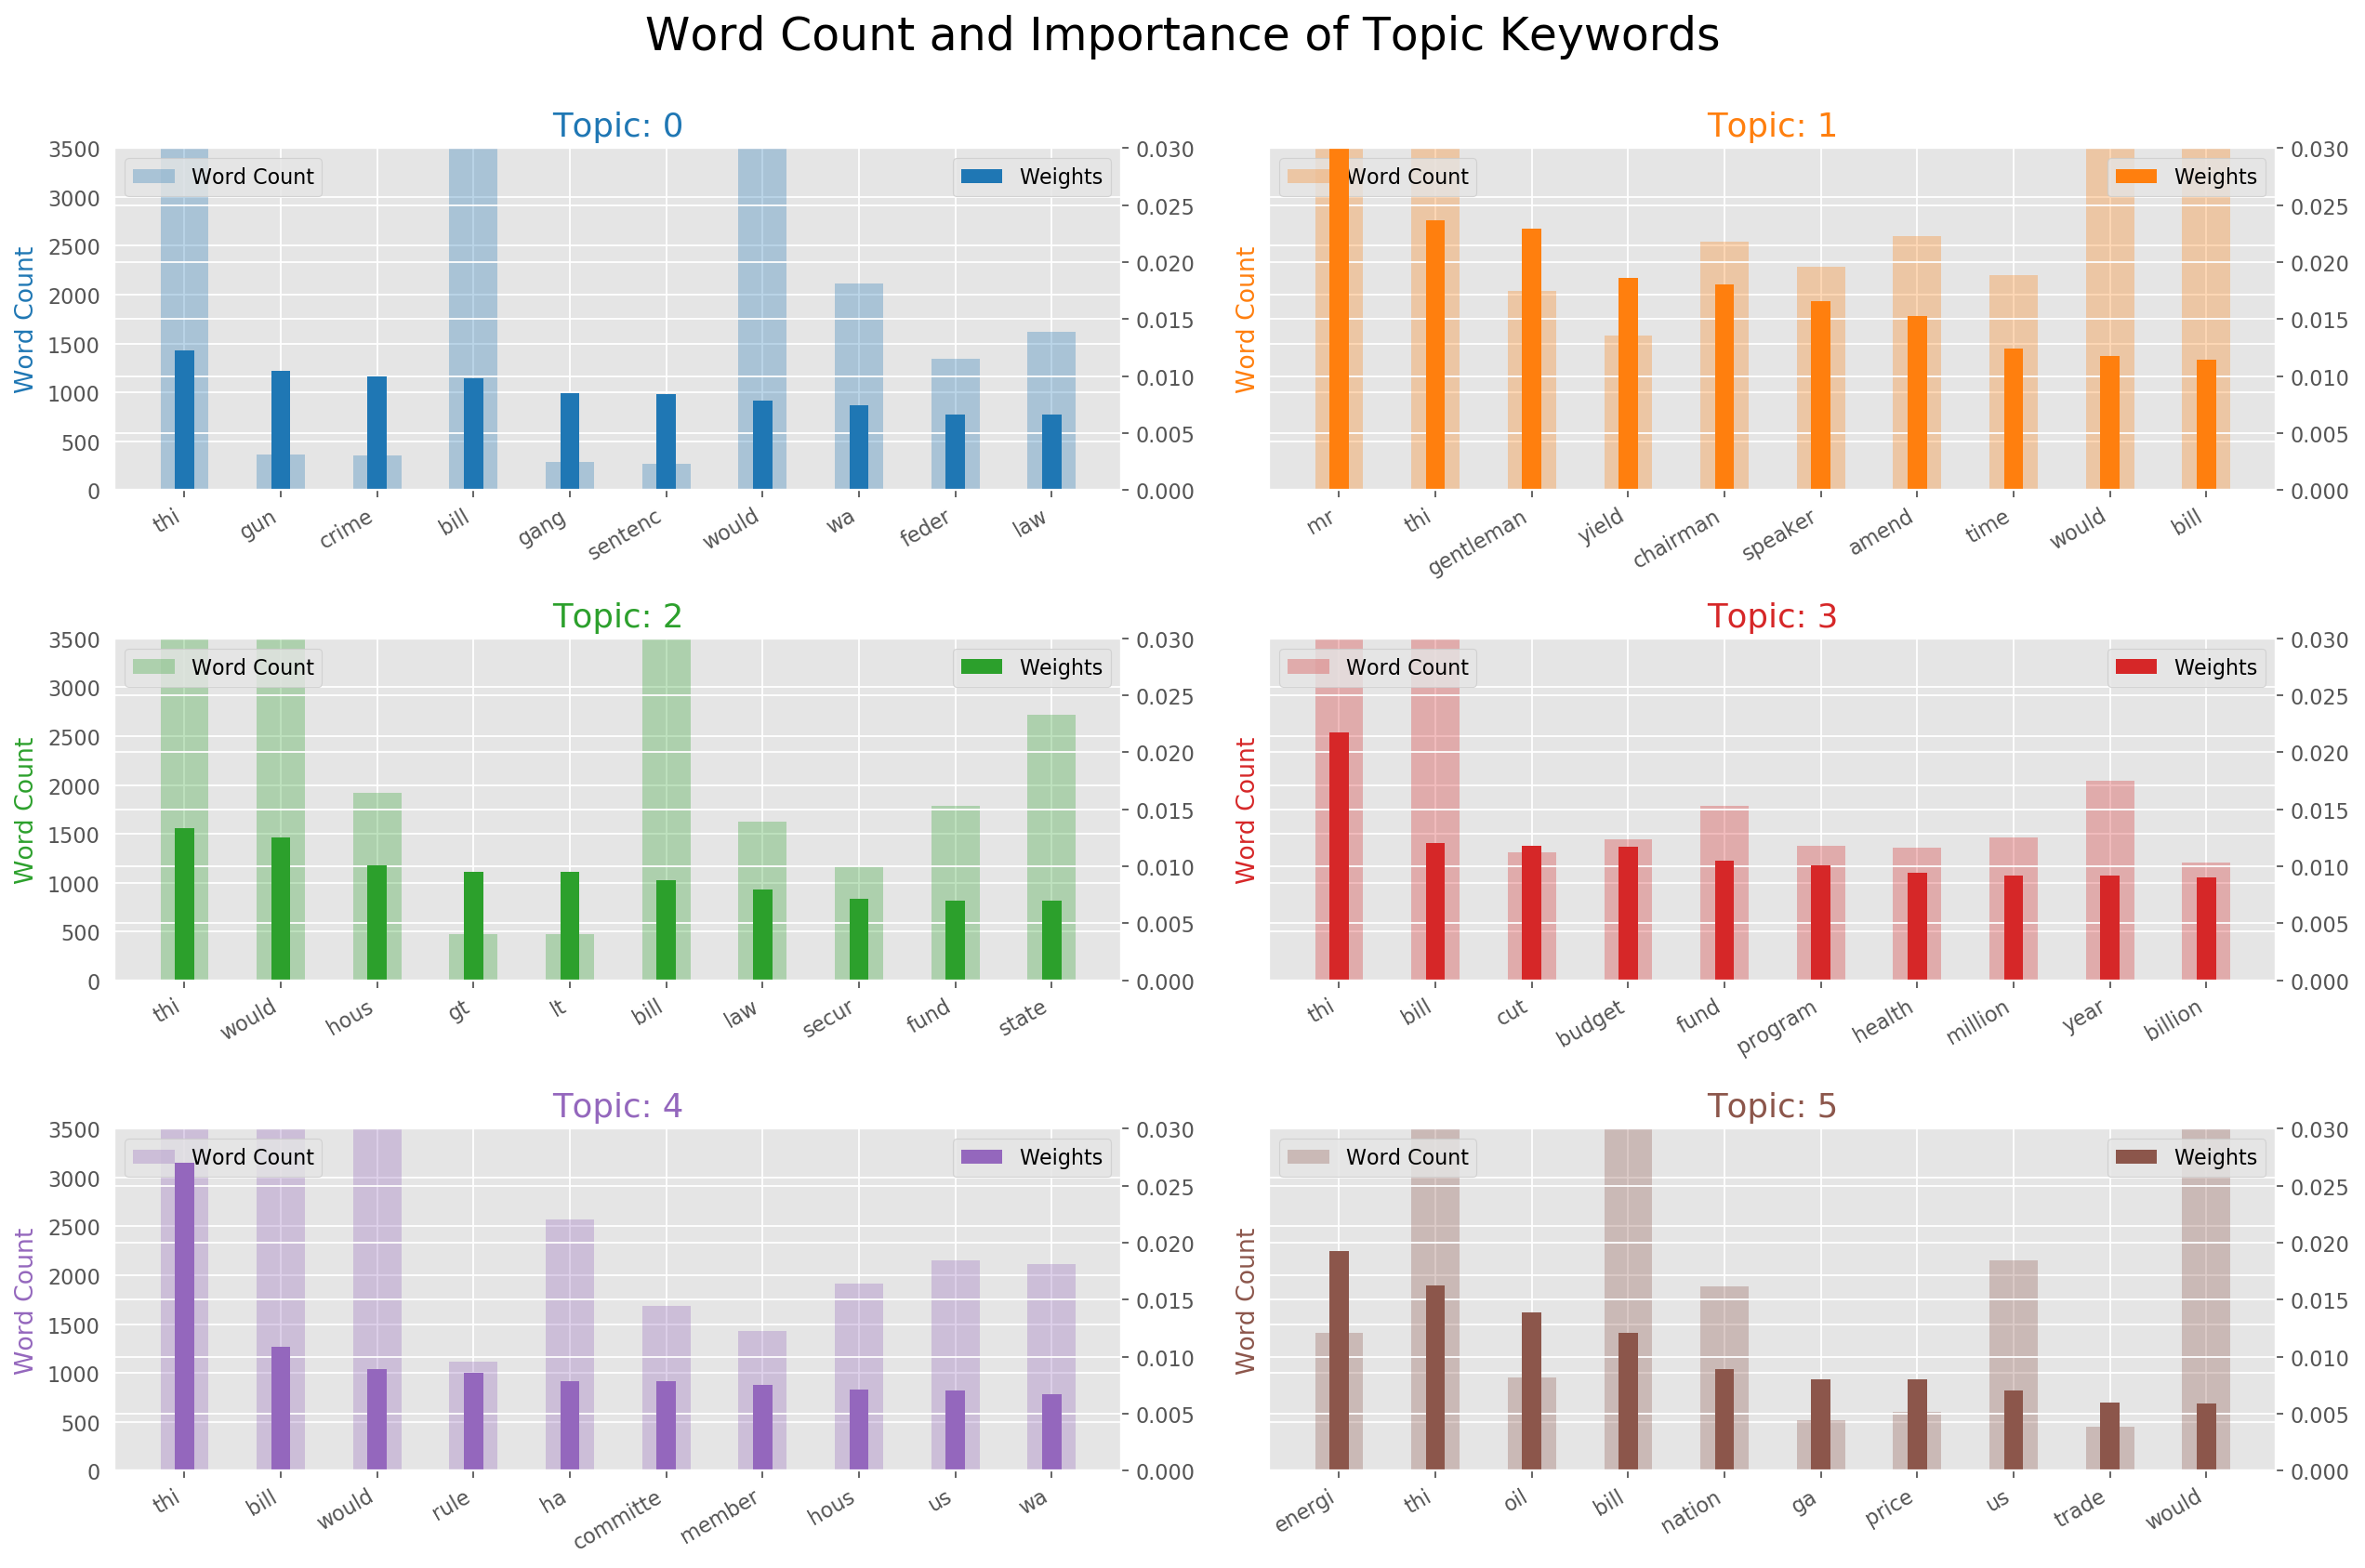

In [65]:
# Visualize word counts and importance of topic keywords
topics = lib_convote_lda.show_topics(formatted=False)
data_flat = [w for w_list in train_lib_convote for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [78]:
# visualize clustering
id2word = corpora.Dictionary(train_lib_convote)
corpus = [id2word.doc2bow(text) for text in train_lib_convote]

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lib_convote_lda[corpus]):
    topic_weights.append([w for i, w in row_list])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

124
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2815 samples in 0.001s...
[t-SNE] Computed neighbors for 2815 samples in 0.050s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2815
[t-SNE] Computed conditional probabilities for sample 2000 / 2815
[t-SNE] Computed conditional probabilities for sample 2815 / 2815
[t-SNE] Mean sigma: 0.000002
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.165997
[t-SNE] KL divergence after 1000 iterations: 0.390827


Loading BokehJS ...

In [59]:
for topic in con_convote_lda.print_topics():
    print(topic)

(0, '0.017*"state" + 0.013*"law" + 0.011*"thi" + 0.010*"gang" + 0.009*"feder" + 0.009*"licens" + 0.008*"terrorist" + 0.008*"support" + 0.008*"secur" + 0.007*"bill"')
(1, '0.026*"thi" + 0.009*"ha" + 0.009*"speaker" + 0.008*"time" + 0.008*"would" + 0.008*"mr" + 0.008*"go" + 0.007*"wa" + 0.007*"peopl" + 0.007*"us"')
(2, '0.016*"pension" + 0.015*"bill" + 0.012*"plan" + 0.011*"thi" + 0.011*"act" + 0.009*"children" + 0.008*"would" + 0.008*"year" + 0.008*"law" + 0.008*"protect"')
(3, '0.040*"mr" + 0.027*"chairman" + 0.024*"gentleman" + 0.024*"committe" + 0.020*"yield" + 0.017*"thi" + 0.015*"speaker" + 0.014*"amend" + 0.014*"time" + 0.010*"hous"')
(4, '0.024*"thi" + 0.009*"bill" + 0.008*"ha" + 0.008*"us" + 0.007*"would" + 0.007*"chairman" + 0.007*"year" + 0.007*"energi" + 0.007*"need" + 0.007*"nation"')
(5, '0.019*"health" + 0.019*"tax" + 0.016*"busi" + 0.015*"thi" + 0.014*"small" + 0.011*"care" + 0.010*"class" + 0.009*"would" + 0.009*"state" + 0.009*"cost"')


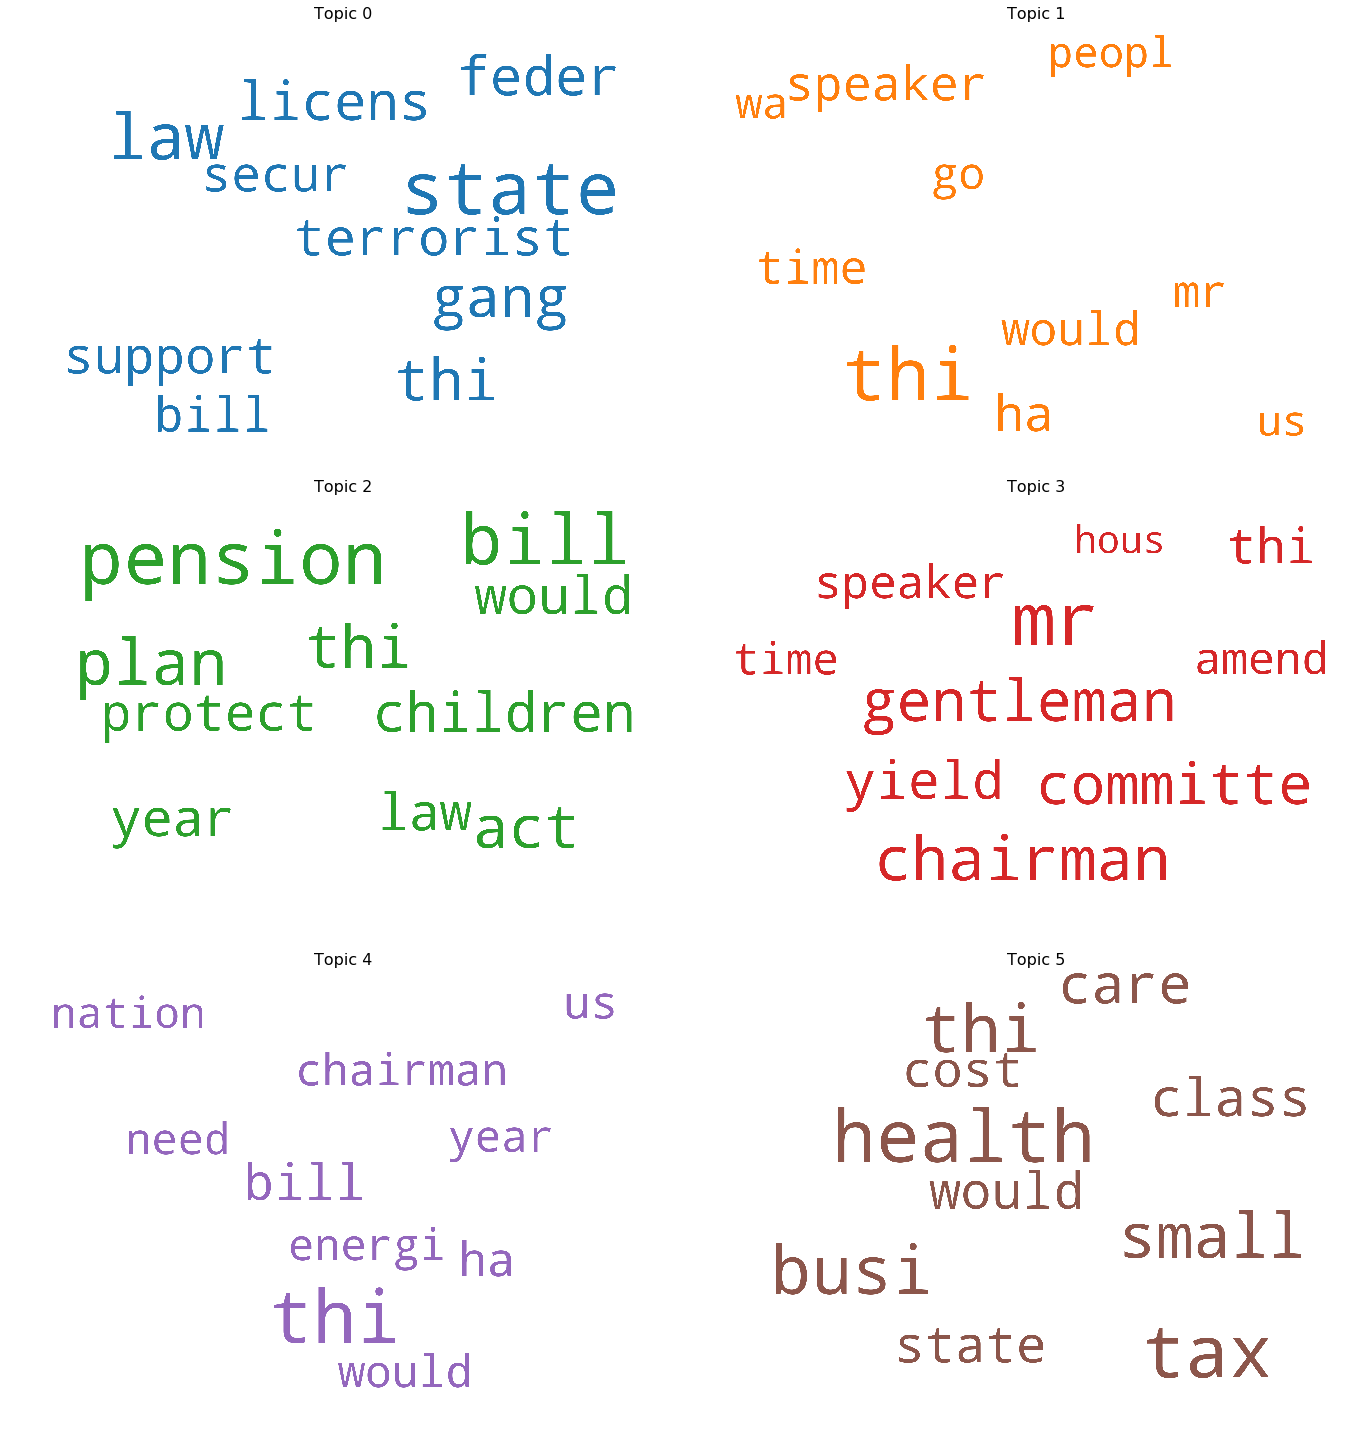

In [60]:
# Visualize the lda topics for conservative corpus
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = con_convote_lda.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

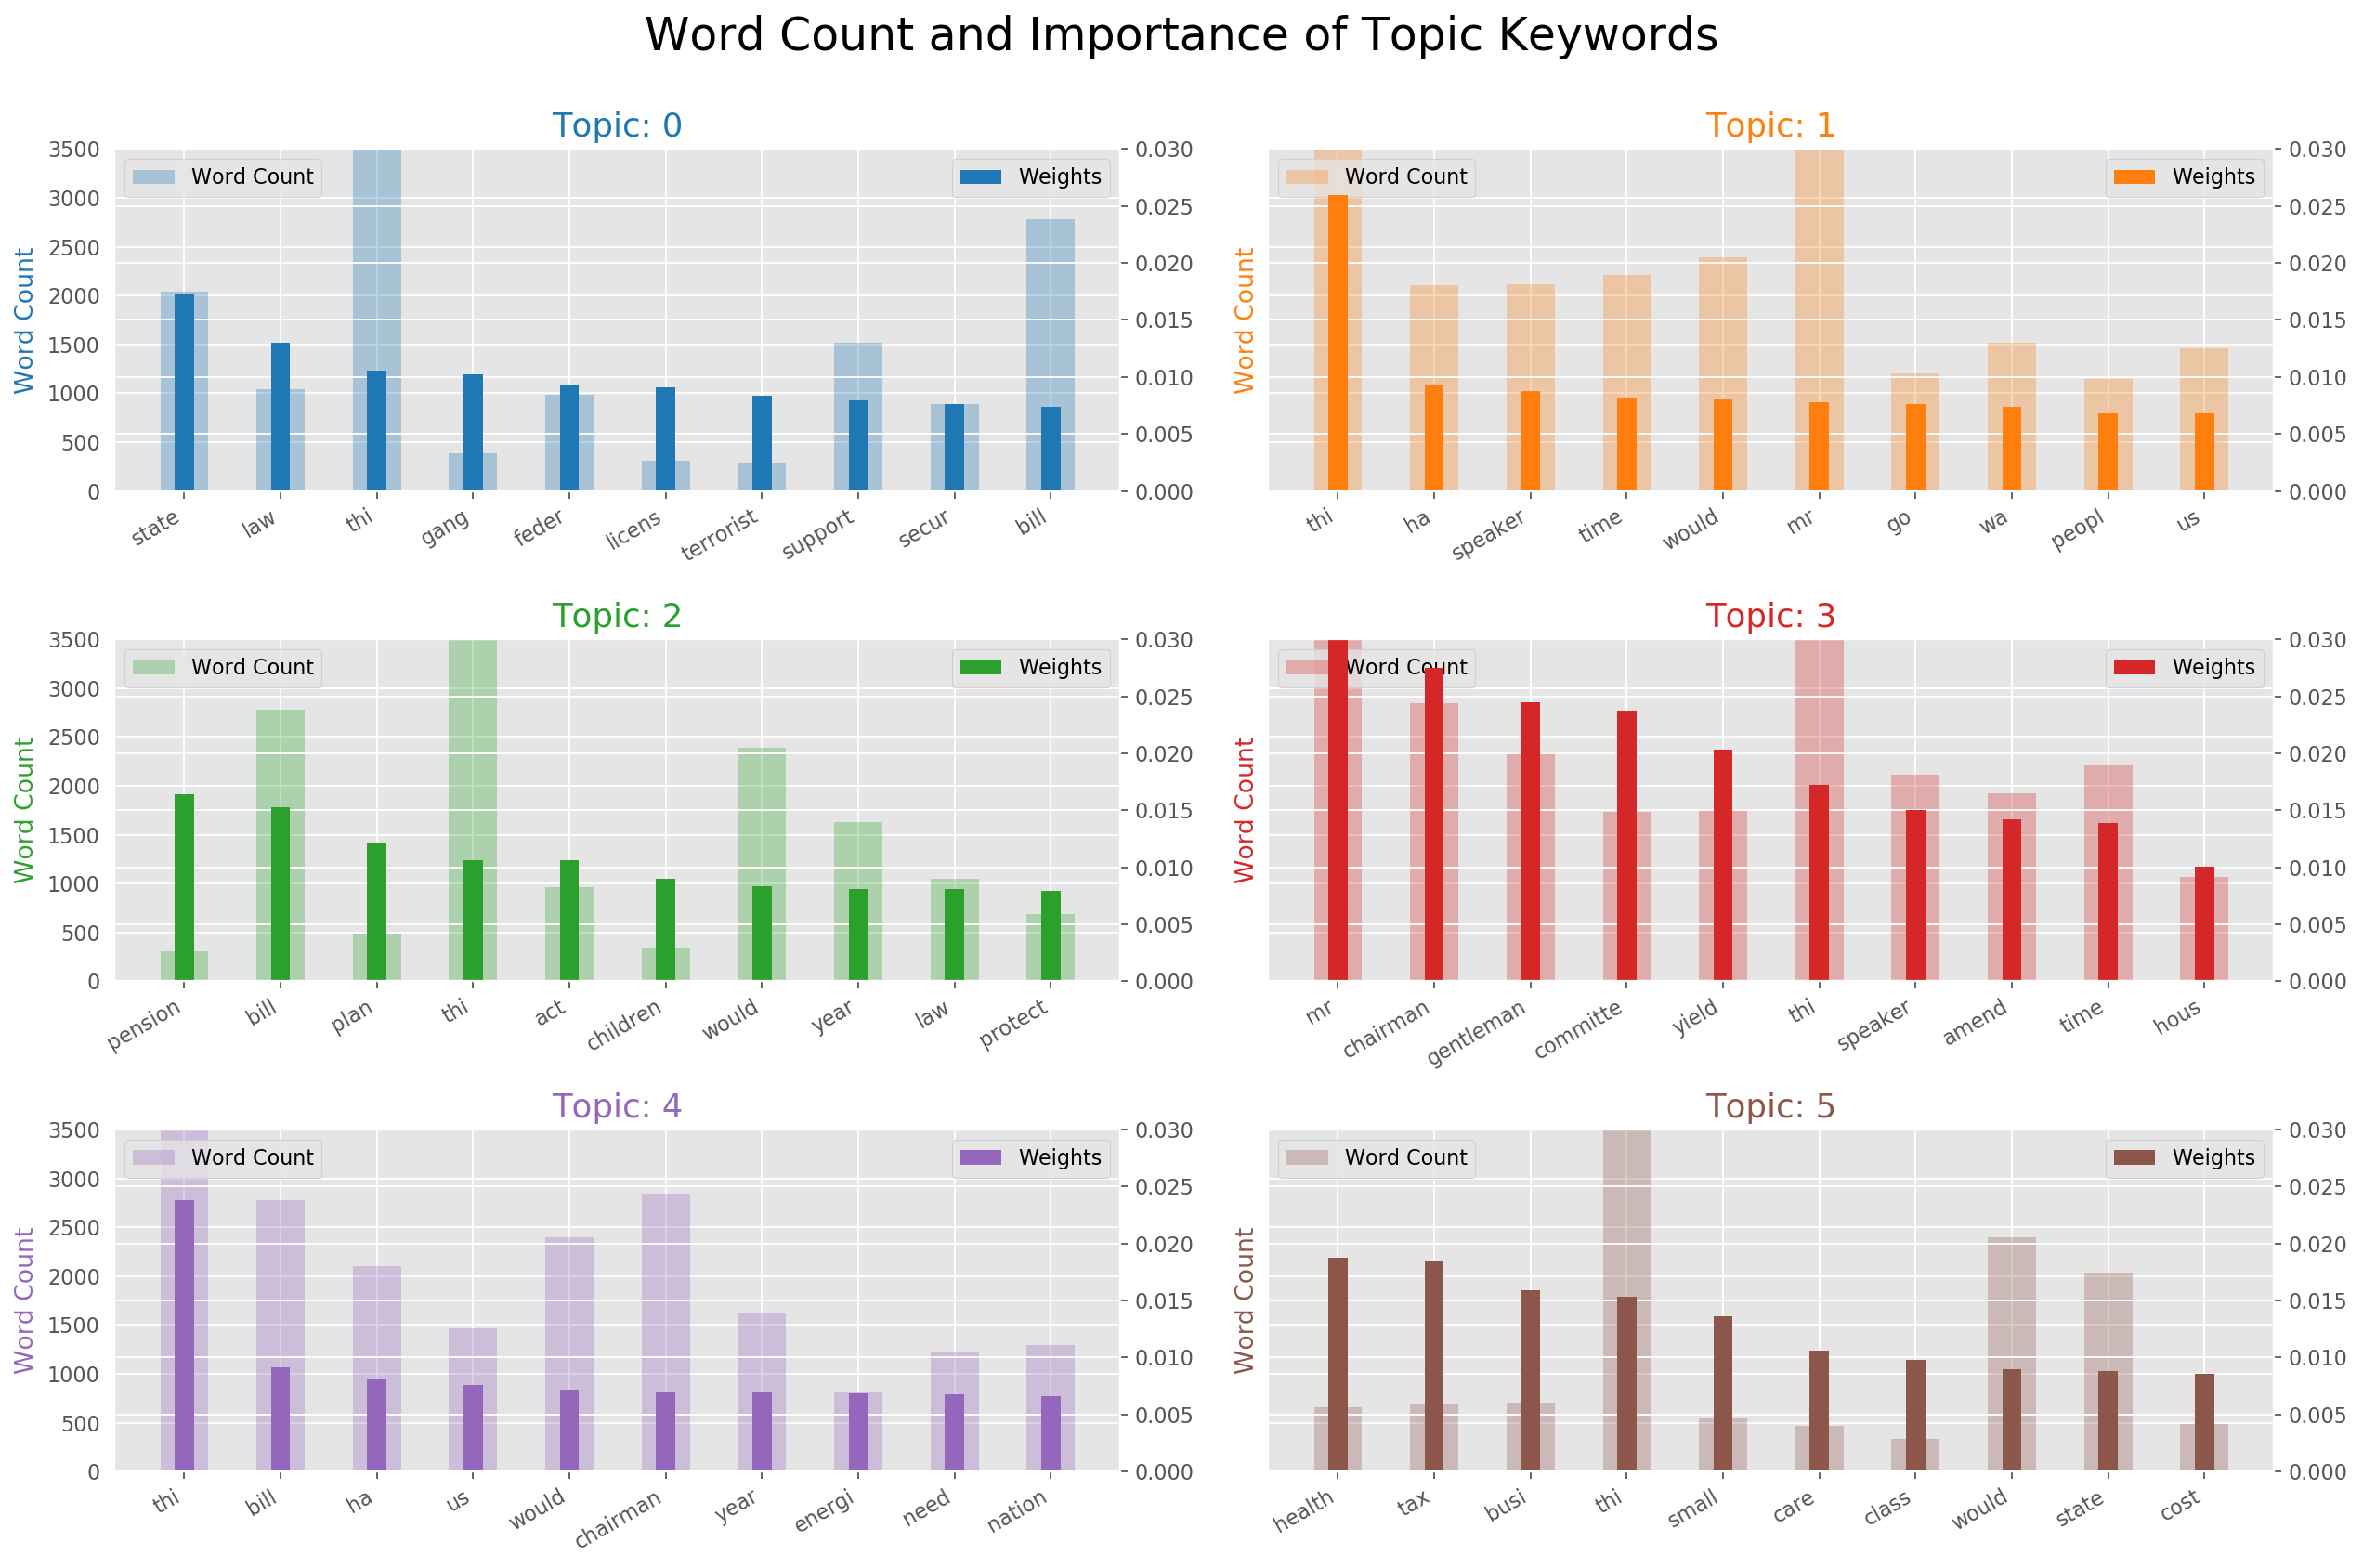

In [66]:
# Visualize word counts and importance of topic keywords
topics = con_convote_lda.show_topics(formatted=False)
data_flat = [w for w_list in train_con_convote for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [77]:
# visualize clustering
id2word = corpora.Dictionary(train_con_convote)
corpus = [id2word.doc2bow(text) for text in train_con_convote]

# Get topic weights
topic_weights = []
for i, row_list in enumerate(con_convote_lda[corpus]):
    topic_weights.append([w for i, w in row_list])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

4
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2769 samples in 0.001s...
[t-SNE] Computed neighbors for 2769 samples in 0.052s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2769
[t-SNE] Computed conditional probabilities for sample 2000 / 2769
[t-SNE] Computed conditional probabilities for sample 2769 / 2769
[t-SNE] Mean sigma: 0.000007
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.274887
[t-SNE] KL divergence after 1000 iterations: 0.396916


Loading BokehJS ...

In [61]:
# Train a lda model on all data
convote_lda = perform_lda(train_convote)

# visualize the topics
for topic in convote_lda.print_topics():
    print(topic)

(0, '0.027*"thi" + 0.010*"committe" + 0.009*"would" + 0.009*"bill" + 0.009*"wa" + 0.008*"ha" + 0.007*"us" + 0.007*"state" + 0.007*"hous" + 0.006*"rule"')
(1, '0.013*"thi" + 0.011*"law" + 0.011*"bill" + 0.009*"would" + 0.008*"feder" + 0.008*"protect" + 0.008*"amend" + 0.007*"state" + 0.007*"gang" + 0.007*"crime"')
(2, '0.020*"thi" + 0.017*"energi" + 0.011*"bill" + 0.011*"oil" + 0.008*"would" + 0.007*"nation" + 0.007*"state" + 0.007*"us" + 0.007*"price" + 0.007*"ga"')
(3, '0.096*"mr" + 0.064*"gentleman" + 0.055*"chairman" + 0.053*"yield" + 0.034*"speaker" + 0.028*"time" + 0.023*"amend" + 0.022*"minut" + 0.013*"committe" + 0.011*"balanc"')
(4, '0.023*"thi" + 0.014*"budget" + 0.014*"fund" + 0.013*"bill" + 0.012*"program" + 0.011*"year" + 0.011*"tax" + 0.010*"million" + 0.010*"cut" + 0.009*"billion"')
(5, '0.017*"thi" + 0.015*"state" + 0.013*"health" + 0.011*"court" + 0.010*"would" + 0.010*"feder" + 0.009*"bill" + 0.009*"case" + 0.009*"busi" + 0.008*"small"')


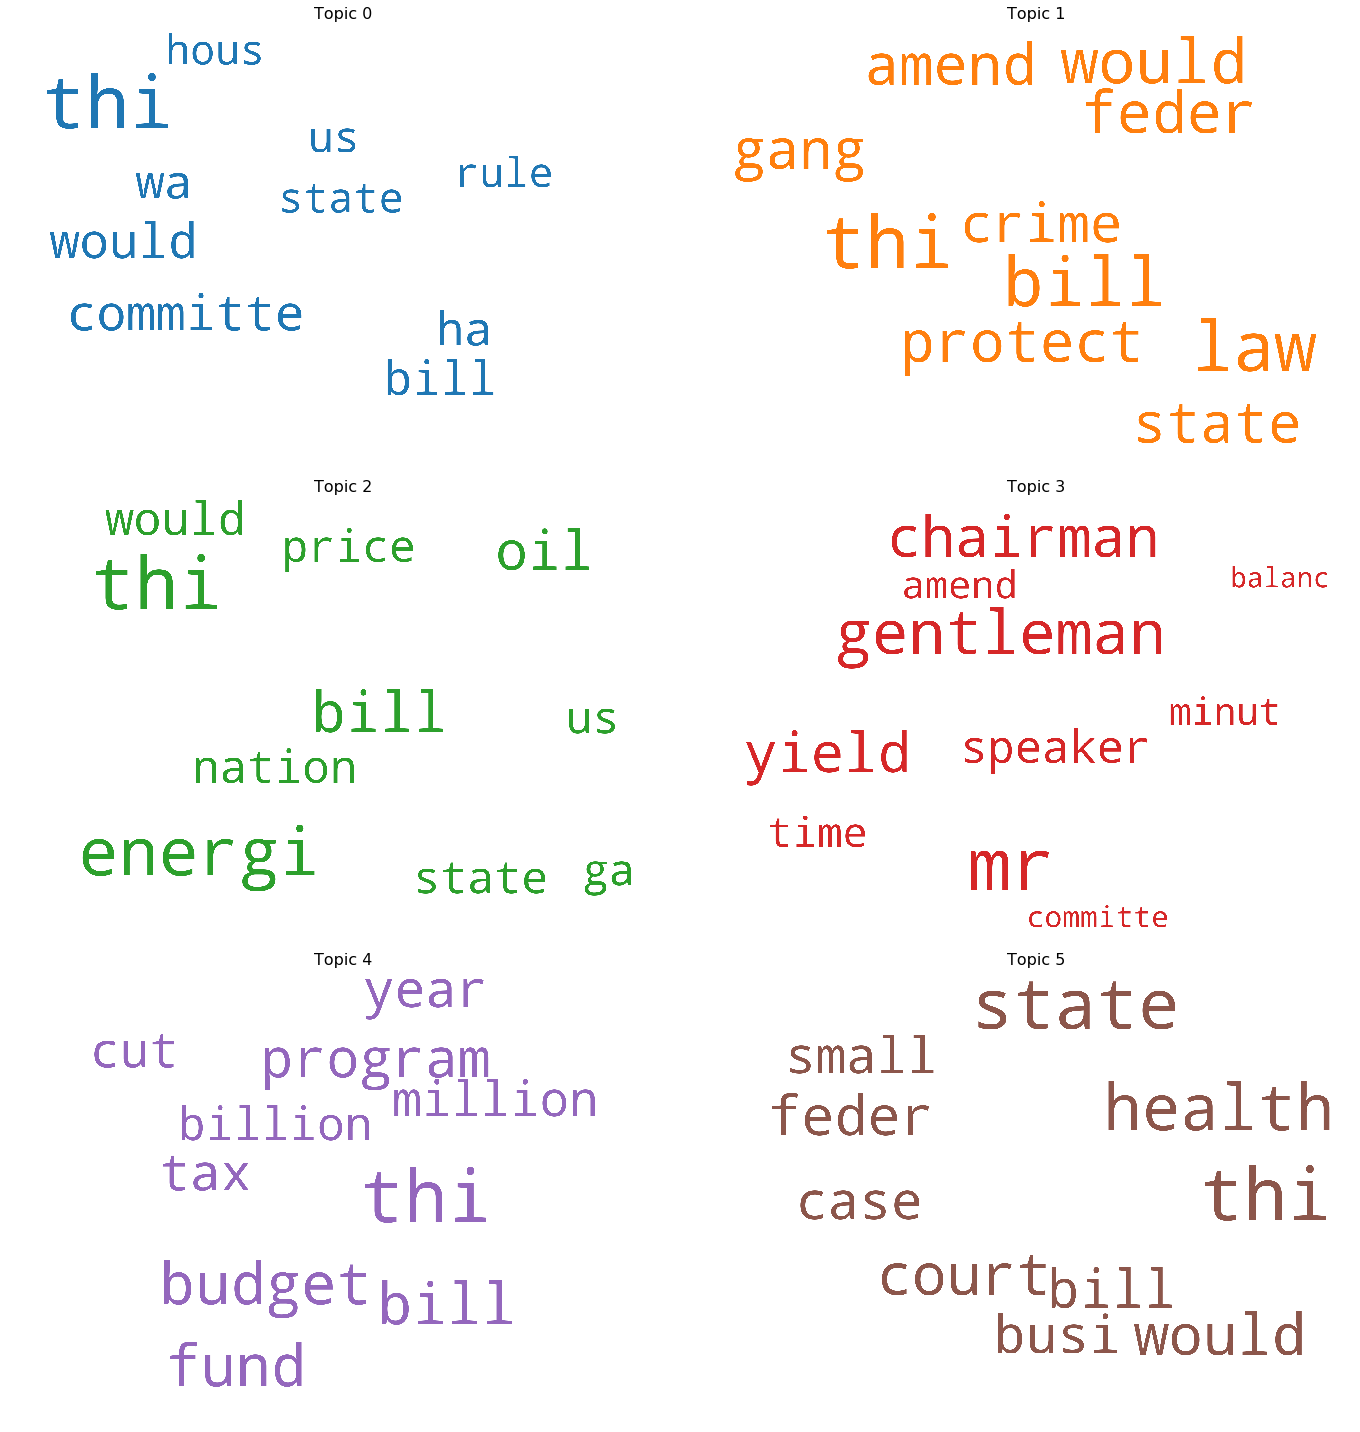

In [62]:
# Visualize the lda topics for conservative corpus
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = convote_lda.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

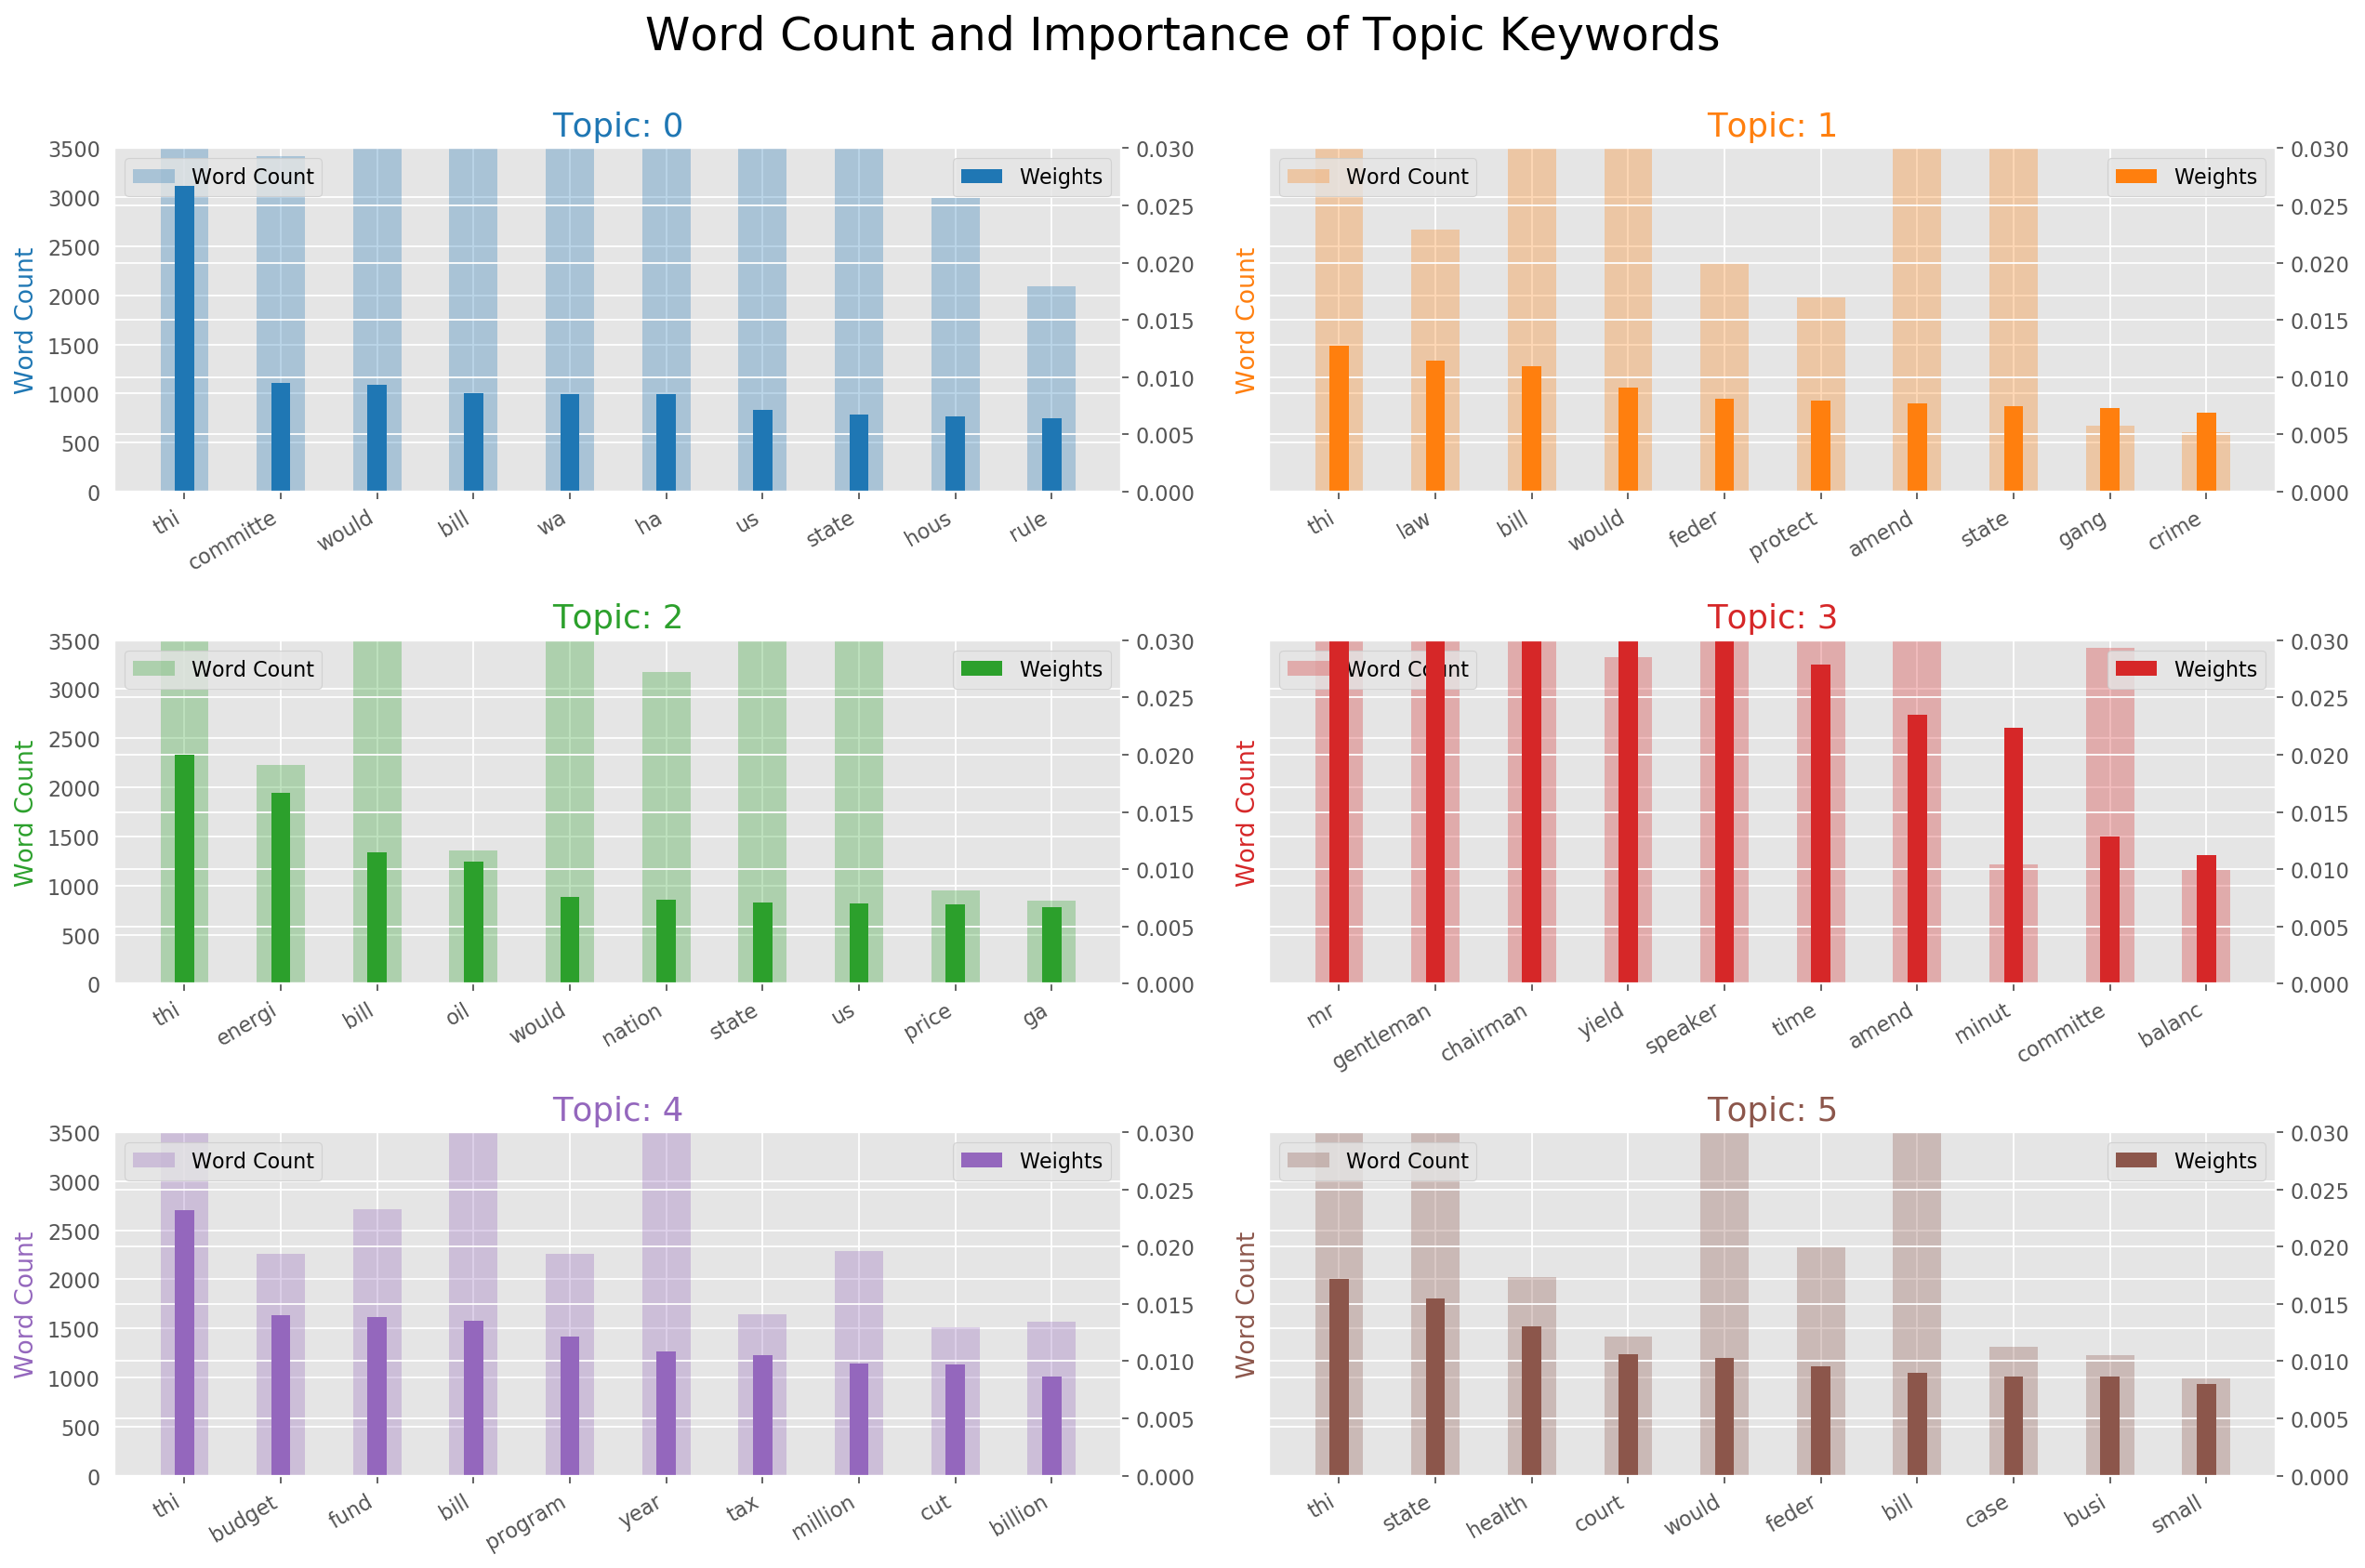

In [67]:
# Visualize word counts and importance of topic keywords
topics = convote_lda.show_topics(formatted=False)
data_flat = [w for w_list in train_convote for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [76]:
# visualize clustering
id2word = corpora.Dictionary(train_convote)
corpus = [id2word.doc2bow(text) for text in train_convote]

# Get topic weights
topic_weights = []
for i, row_list in enumerate(convote_lda[corpus]):
    topic_weights.append([w for i, w in row_list])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

124
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5585 samples in 0.008s...
[t-SNE] Computed neighbors for 5585 samples in 0.126s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5585
[t-SNE] Computed conditional probabilities for sample 2000 / 5585
[t-SNE] Computed conditional probabilities for sample 3000 / 5585
[t-SNE] Computed conditional probabilities for sample 4000 / 5585
[t-SNE] Computed conditional probabilities for sample 5000 / 5585
[t-SNE] Computed conditional probabilities for sample 5585 / 5585
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.944576
[t-SNE] KL divergence after 1000 iterations: 0.549347


Loading BokehJS ...

#### Naive Bayes Model

In [28]:
# set up count-based and tfidf-based naive bayesian model

def cont_vect_nb(input_corpus, input_label):
    '''
        convert the input corpus to a counter vectorizer 
        train a naive bayes model based on the input matirx
        
        parameters
        input_corpus: a list of document in token format
        input_label: a list of labels 
        return:
        clf: the trained naive bayes model
    '''
    #vectorizer = CountVectorizer()
    #train_data = vectorizer.fit_transform(input_corpus)
    clf = GaussianNB()
    clf.fit(input_corpus, input_label)
    return clf

def pre_tfidf(input_corpus):
    '''
        pre-tfidf step to convert corpus to format which 
        can be takens as the argument to the tfidf naive 
        bayesian model
        
        parameters:
        input_corpus: a list of document in token format
        return:
        result: a list of tokens with each tokens as a complete 
            sentence comprised by preprocessed token lists
    '''
    counter = 0
    result = []
    print('Start pre-tfidf parsing')
    
    for doc in input_corpus:
        temp = ''
        for tok in doc:
            temp += tok
            temp += ' '
        temp = temp.strip(' ')
        result.append(temp)
        
        if counter % 200 == 0:
            print('Finished {} documents'.format(counter))
        counter += 1
    print('{} documents parsed'.format(counter))
    print('Done')
    return result

def tfidf_vect_nb(input_corpus, input_label, n_gram=1, min_df=5, max_vocab=20000, input_vocab = None):
    '''
        convert the input corpus to a tfidf vectorizer 
        train a naive bayes model based on the input matirx
        
        parameters
        input_corpus: a list of document in token format
        input_label: a list of labels 
        return:
        clf: the trained naive bayes model
        vectorizer: trained vectorizer
    '''
    input_corpus = pre_tfidf(input_corpus)
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,n_gram),
                                min_df = min_df, max_features = max_vocab,
                                vocabulary = input_vocab)
    vectorizer.fit(input_corpus)
    train_data = vectorizer.transform(input_corpus)
    train_data = train_data.todense()
    #input_label = np.array(input_label)
    #input_label = input_label.todense()
    #print(train_data.shape)
    #print(input_label.shape)
    clf = GaussianNB()
    clf.fit(train_data, input_label)
    return clf, vectorizer

def tfidf_vect_nb(input_corpus, input_label):
    '''
        convert the input corpus to a tfidf vectorizer 
        train a naive bayes model based on the input matirx
        
        parameters
        input_corpus: a list of document in token format
        input_label: a list of labels 
        return:
        clf: the trained naive bayes model
        vectorizer: trained vectorizer
    '''
    transformer = TfidfTransformer()
    
    transformer.fit(input_corpus)
    train_data = transformer.transform(input_corpus)
    train_data = train_data.todense()
    clf = GaussianNB()
    clf.fit(train_data, input_label)
    return clf, transformer

In [20]:
# train the count based naive bayes model and make prediction
train_convote = preprocess_text(s1_training_contents)

convote_all_tokens = find_all_tokens(train_convote)
convote_id2tokens, convote_tokens2id = build_vocab(convote_all_tokens)
train_data = convert_sparse_matrix(train_convote, convote_id2tokens)

develop_convote = preprocess_text(s1_develop_contents)
develop_data = convert_sparse_matrix(develop_convote, convote_id2tokens)

Start finding all tokens
Finished loading 0 documents
Finished loading 200 documents
Finished loading 400 documents
Finished loading 600 documents
Finished loading 800 documents
Finished loading 1000 documents
Finished loading 1200 documents
Finished loading 1400 documents
Finished loading 1600 documents
Finished loading 1800 documents
Finished loading 2000 documents
Finished loading 2200 documents
Finished loading 2400 documents
Finished loading 2600 documents
Finished loading 2800 documents
Finished loading 3000 documents
Finished loading 3200 documents
Finished loading 3400 documents
Finished loading 3600 documents
Finished loading 3800 documents
Finished loading 4000 documents
Finished loading 4200 documents
Finished loading 4400 documents
Finished loading 4600 documents
Finished loading 4800 documents
Finished loading 5000 documents
Finished loading 5200 documents
Finished loading 5400 documents
Finished loading 5600 documents
5634 documents parsed
Done
Start building sparse docum

In [32]:
# fit count-based NB model
clf_count = cont_vect_nb(train_data, s1_training_labels)

# model evaluation
prediction_score = clf_count.score(develop_data, s1_develop_labels)
prediction = clf_count.predict(develop_data)
count_confusion_matrix = confusion_matrix(s1_develop_labels, prediction)
print('The prediction score of the count-based nb model is {}'.format(prediction_score))
print('The confusion matrix for the count-based naive bayes model is:')
print(count_confusion_matrix)

The prediction score of the count-based nb model is 0.584045584045584
The confusion matrix for the count-based naive bayes model is:
[[288  79]
 [213 122]]


In [33]:
# fit tfidf-baed NB model
train_data = convert_sparse_matrix(train_convote, convote_id2tokens)
develop_data = convert_sparse_matrix(develop_convote, convote_id2tokens)
clf_tfidf, tfidf_vectorizer = tfidf_vect_nb(train_data, s1_training_labels)

# model evaluation
prediction_score = clf_tfidf.score(develop_data, s1_develop_labels)
prediction_tfidf = clf_tfidf.predict(develop_data)
tfidf_confusion_matrix = confusion_matrix(s1_develop_labels, prediction_tfidf)
print('The prediction score of the count-based nb model is {}'.format(prediction_score))
print('The confusion matrix for the tfidf-based naive bayes model is:')
print(tfidf_confusion_matrix)

Start building sparse document matrix
Finished 0 documents
Finished 200 documents
Finished 400 documents
Finished 600 documents
Finished 800 documents
Finished 1000 documents
Finished 1200 documents
Finished 1400 documents
Finished 1600 documents
Finished 1800 documents
Finished 2000 documents
Finished 2200 documents
Finished 2400 documents
Finished 2600 documents
Finished 2800 documents
Finished 3000 documents
Finished 3200 documents
Finished 3400 documents
Finished 3600 documents
Finished 3800 documents
Finished 4000 documents
Finished 4200 documents
Finished 4400 documents
Finished 4600 documents
Finished 4800 documents
Finished 5000 documents
Finished 5200 documents
Finished 5400 documents
Finished 5600 documents
5634 documents parsed
Done
Start building sparse document matrix
Finished 0 documents
Finished 200 documents
Finished 400 documents
Finished 600 documents
702 documents parsed
Done
The prediction score of the count-based nb model is 0.6296296296296297
The confusion matrix 

#### Rnn model

In [11]:
def create_placeholder(vocab_size, num_time_step, batch_size, num_topics):
    '''
        create tensorflow placeholer for three input sets for the model
        
        parameters:
        vocab_size: total number of input dimensions (equal to the size of the dictionary)
        num_time_step: total number of time steps (equal to the maximum length of sentences)
        batch_size: the number of samples in each batch
        num_topic: input dimension for the topic vector
        returns:
        X_rnn: the tensorflow placeholer for the input data for rnn model
        y: the tensorflow placeholder for the label set
        X_topic: the tensorflow placeholder for the input data for topic vector 
    '''
    X_rnn = tf.placeholder(tf.float32, [batch_size, num_time_step, vocab_size], name='X_rnn')
    y = tf.placeholder(tf.float32, [batch_size], name='y')
    X_topic = tf.placeholder(tf.float32, [batch_size, num_topics], name='X_topic')
    #state = tf.placeholder(tf.float32, [batch_size, num_time_step], name="state")
    
    return X_rnn, y, X_topic#, state

def init_parameter(num_hidden, num_fcn_hidden, num_topics, num_timestep, num_classes=1):
    '''
        initialize the parameters for the deep learning model
        
        parameters:
        num_hidden: the dimension of hidden layer of rnn model
        num_fcn_hidden: the dimension of the hidden layer 
            of the fully connected neural network
        num_topics: the dimension of the topic vector
        num_classes: the number of output classes
        num_timestep: the length of the input sentence
        return:
        parameters: the dictionary with key as the 
            name of the parameters and value as the 
            corresponding tensorflow variables
    '''
    tf.set_random_seed(1) 
    
    w1 = tf.get_variable('w1', [num_fcn_hidden, num_hidden+num_topics], 
                         initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable('b1', [num_fcn_hidden, 1],
                        initializer = tf.zeros_initializer())
    w2 = tf.get_variable('w2', [num_classes, num_fcn_hidden],
                        initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable('b2', [num_classes, 1], 
                        initializer = tf.zeros_initializer())
    
    parameters = {'w1':w1,
                  'b1':b1,
                  'w2':w2,
                  'b2':b2,}
    return parameters

In [12]:
def forward_prop(X_rnn, X_topic, parameters, num_hidden, num_timestep):
    '''
        the function for forward propogation for the specified deep learning model
        
        parameters:
        X_rnn: the input data to feed into rnn model
        X_topic: the input data to be concatenated with output of rnn model
        init_state: the initial state for rnn model
        parameters: a dictionary which contains all necessary parameters for the model
        return:
        Z3: the last layer of the fully connected neural network
    '''
    # unpack the parameters
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    
    # set up the computational graph
    temp_X = tf.unstack(X_rnn, num_timestep, 1)
    
    lstm_cell = rnn_cell.BasicLSTMCell(num_hidden, forget_bias=1.0)
    #lstm_cell = rnn_cell.BasicRNNCell(num_hidden)
    
    outputs, states = static_rnn(lstm_cell, temp_X, dtype=tf.float32)
    #outputs, states = tf.keras.layers.RNN(lstm_cell, unroll=True)
    #outputs, states = rnn.static_rnn(lstm_cell, temp_X)
    
    X = tf.concat([outputs[-1],X_topic], 1)
    Z1 = tf.add(tf.matmul(w1, tf.transpose(X)), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.transpose(tf.add(tf.matmul(w2,A1), b2))
    
    return Z2

In [13]:
def compute_cost(Z, y):
    '''
        compute cost for the model
        
        parameters:
        Z3: the output for the last layer of the fully connected neural network
        y: the label set of the data
        return:
        cost: the cost of the results
    '''
    logits = tf.transpose(Z)
    labels = tf.transpose(y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

In [14]:
def convert_to_rnn_input(input_corpus, tokens2id, vocab_size=5000, max_sentence_length=150):
    '''
        the function to convert input corpus in token format to numeric format
        
        parameters:
        input_corpus: input corpus in token format
        tokens2id: the look up dictionary 
        max_sentence_length: the dimension for the vector for every input token
        returns:
        result: the input data in numeric format for rnn model
    '''
    result = np.zeros([len(input_corpus), max_sentence_length, vocab_size])
    counter = 0
    
    for doc in input_corpus:
        temp = []
        inner_counter = 0
        
        sentence_length = len(doc)
        if sentence_length > max_sentence_length:
            doc_temp = doc[:max_sentence_length]
            while inner_counter < max_sentence_length:
                idx = 1
                if doc_temp[inner_counter] in tokens2id:
                    idx = tokens2id[doc_temp[inner_counter]]
                result[counter, inner_counter, idx] = 1
                inner_counter += 1
        else:
            doc_add = ['<pad>' for i in range(max_sentence_length - len(doc))]
            doc_temp = doc + doc_add
            while inner_counter < max_sentence_length:
                idx = 1
                if doc_temp[inner_counter] in tokens2id:
                    idx = tokens2id[doc_temp[inner_counter]]
                result[counter, inner_counter, idx] = 1
                inner_counter += 1
        if counter % 200 == 0:
            print('Converted {} documents'.format(counter))
        counter += 1
    
    print('{} documents have been converted'.format(counter))
    print('Finished')
    return result

def convert_topic_vector(input_corpus, trained_lda, bench_corpus, num_topics):
    '''
        the function to convert documents to ducoment topic vector
        
        parameters:
        input_corpus: the coprus to be converted
        trained_lda: the trained lda model
        bench_corpus: the bench mark corpus for lda conversion
        return:
        result: the converted corpus for deep learning model
    '''
    result = []
    counter = 0
    
    temp_doc = perform_convert(input_corpus, bench_corpus)
    for doc in temp_doc:
        temp_topic = trained_lda.get_document_topics(doc)
        #print(temp_topic)
        temp = np.zeros(num_topics)
        if len(temp_topic) == 0:
            result.append(temp)
            continue
        else:
            for item in temp_topic:
                (idx, val) = item[0], item[1]
                temp[idx] = val
            result.append(temp)
        if counter % 200 == 0:
            print('Finished {} documents'.format(counter))
        counter += 1
    
    print('{} documents parsed'.format(counter))
    return np.array(result)

In [15]:
# train the count based naive bayes model and make prediction
train_convote = preprocess_text(s1_training_contents)

convote_all_tokens = find_all_tokens(train_convote)
convote_id2tokens, convote_tokens2id = build_vocab(convote_all_tokens)
train_data = convert_sparse_matrix(train_convote, convote_id2tokens)

develop_convote = preprocess_text(s1_develop_contents)
develop_data = convert_sparse_matrix(develop_convote, convote_id2tokens)

Start finding all tokens
Finished loading 0 documents
Finished loading 200 documents
Finished loading 400 documents
Finished loading 600 documents
Finished loading 800 documents
Finished loading 1000 documents
Finished loading 1200 documents
Finished loading 1400 documents
Finished loading 1600 documents
Finished loading 1800 documents
Finished loading 2000 documents
Finished loading 2200 documents
Finished loading 2400 documents
Finished loading 2600 documents
Finished loading 2800 documents
Finished loading 3000 documents
Finished loading 3200 documents
Finished loading 3400 documents
Finished loading 3600 documents
Finished loading 3800 documents
Finished loading 4000 documents
Finished loading 4200 documents
Finished loading 4400 documents
Finished loading 4600 documents
Finished loading 4800 documents
Finished loading 5000 documents
Finished loading 5200 documents
Finished loading 5400 documents
Finished loading 5600 documents
5634 documents parsed
Done
Start building sparse docum

In [16]:
# train a lda model based on the training set
trained_lda = perform_lda(train_convote, num_topic=10)

In [17]:
# Prepare input data 
X_rnn_train = convert_to_rnn_input(train_convote, convote_tokens2id)
X_topic_train = convert_topic_vector(train_convote, trained_lda, train_convote, 5)
y_train = np.array(s1_training_labels)


X_rnn_test = convert_to_rnn_input(develop_convote, convote_tokens2id)
X_topic_test = convert_topic_vector(develop_convote, trained_lda, train_convote, 5)
y_test = np.array(s1_develop_labels)

Converted 0 documents
Converted 200 documents
Converted 400 documents
Converted 600 documents
Converted 800 documents
Converted 1000 documents
Converted 1200 documents
Converted 1400 documents
Converted 1600 documents
Converted 1800 documents
Converted 2000 documents
Converted 2200 documents
Converted 2400 documents
Converted 2600 documents
Converted 2800 documents
Converted 3000 documents
Converted 3200 documents
Converted 3400 documents
Converted 3600 documents
Converted 3800 documents
Converted 4000 documents
Converted 4200 documents
Converted 4400 documents
Converted 4600 documents
Converted 4800 documents
Converted 5000 documents
Converted 5200 documents
Converted 5400 documents
Converted 5600 documents
5634 documents have been converted
Finished
Finished 0 documents
Finished 200 documents
Finished 400 documents
Finished 600 documents
Finished 800 documents
Finished 1000 documents
Finished 1200 documents
Finished 1400 documents
Finished 1600 documents
Finished 1800 documents
Finis

In [25]:
def make_minibatch_idx(num_samples, batch_size):
    '''
        make a random batch idx list for mini-batch training
        
        parameters:
        num_samples: the total number of input samples
        batch_size: the dimension of the batch size
        return:
        idx_list: a 2-d list with each array to be a random list of idx of items
    '''
    total_batch = int(num_samples/batch_size)
    
    idx_list = []
    available_idx = [i for i in range(num_samples)]
    for i in range(total_batch):
        temp_idx = np.random.choice(available_idx, batch_size, replace=False)
        idx_list.append(temp_idx)
        available_idx = [i for i in available_idx if i not in temp_idx]
    return idx_list         
    
def rnn_lda_model(X_train, y_train, X_topic_train, X_develop, y_develop, X_topic_develop, num_topics, num_fcn_hidden, 
                  num_hidden, learning_rate = 0.001, num_epochs= 2000, batch_size=32, print_cost = True):
    '''
        
    '''
    ops.reset_default_graph() 
    tf.set_random_seed(1)  
    seed = 3
    
    costs = []
    
    # Adjust the dimension of the input matrix
    (n_x, time_step, n_features) = X_train.shape

    # initialization
    X, Y, X_topic = create_placeholder(n_features, time_step, batch_size, num_topics)
    
    parameters = init_parameter(num_hidden, num_fcn_hidden, num_topics, time_step)
    
    #current_state = tf.convert_to_tensor(np.random.randn(batch_size*num_hidden))
    
    # forward propogation 
    Z2 = forward_prop(X, X_topic, parameters, num_hidden, time_step)
    
    cost = compute_cost(Z2, Y)
    
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    # Calculate the correct predictions
    correct_prediction = tf.equal(tf.argmax(tf.cast(tf.math.round(Z2), dtype=tf.int32)), tf.argmax(Y))
    
    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        # Calculate the correct predictions
        #correct_prediction = tf.equal(tf.argmax(tf.cast(tf.math.round(Z2), dtype=tf.int32)), tf.argmax(Y))
        
        # Calculate accuracy on the test set
        #accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        for epoch_idx in range(num_epochs):
            
            epoch_cost = 0
            epoch_accuracy = 0
            
            seed = seed + 1
            batch_idx = make_minibatch_idx(n_x, batch_size)
            
            for idx in batch_idx:
                input_X_rnn = X_train[idx]
                input_y = y_train[idx]
                input_X_topic = X_topic_train[idx]
            
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: input_X_rnn,
                                                                            X_topic: input_X_topic,
                                                                            Y: input_y})
                epoch_cost += minibatch_cost / len(batch_idx)
                temp_accuracy = accuracy.eval({X: input_X_rnn, X_topic: input_X_topic, Y: input_y})
                epoch_accuracy += temp_accuracy / len(batch_idx)
            # Print the cost every epoch
            if print_cost == True:
                print ("Cost after epoch %i: %f" % (epoch_idx, epoch_cost))
            costs.append(epoch_cost)
            
            print('epoch {} accuracy = {}'.format(epoch_idx, epoch_accuracy))
                
        # lets save the parameters in a variable
        print(parameters)
        result = sess.run(parameters)
        print ("Parameters have been trained!")
        
        # Calculate the correct predictions
        #correct_prediction = tf.equal(tf.argmax(tf.cast(tf.math.round(Z2), dtype=tf.int32)), tf.argmax(Y))
        
        # Calculate accuracy on the test set
        #accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        # Evaluation for training data
        batch_idx = make_minibatch_idx(n_x, batch_size)
        accuracy_train = 0
        for idx in batch_idx:
            input_X_rnn = X_train[idx]
            input_y = y_train[idx]
            input_X_topic = X_topic_train[idx]
            
            temp_accuracy = accuracy.eval({X: input_X_rnn, X_topic: input_X_topic, Y: input_y})
            
            accuracy_train += temp_accuracy / len(batch_idx)
            
        print ("Train Accuracy: {}".format(accuracy_train))
        
        # Evaluation for test data
        batch_idx = make_minibatch_idx(X_develop.shape[0], batch_size)
        accuracy_test = 0
        for idx in batch_idx:
            input_X_rnn = X_develop[idx]
            input_y = y_develop[idx]
            input_X_topic = X_topic_develop[idx]
            
            temp_accuracy = accuracy.eval({X: input_X_rnn, X_topic: input_X_topic, Y: input_y})
            
            accuracy_test += temp_accuracy / len(batch_idx)
            
        print ("Test Accuracy: {}".format(accuracy_test))
        
        return result

In [27]:
parameters = rnn_lda_model(X_rnn_train, y_train, X_topic_train, X_rnn_test, y_test, X_topic_test, num_topics=5, num_fcn_hidden=20, 
                  num_hidden=100, learning_rate = 0.001, num_epochs= 100, batch_size=128, print_cost = True)

Cost after epoch 0: 314.945940
epoch 0 accuracy = 0.4772727272727271
Cost after epoch 1: 313.788866
epoch 1 accuracy = 0.5909090909090907
Cost after epoch 2: 313.909850
epoch 2 accuracy = 0.49999999999999983
Cost after epoch 3: 313.797175
epoch 3 accuracy = 0.4545454545454544
Cost after epoch 4: 313.944637
epoch 4 accuracy = 0.4545454545454544
Cost after epoch 5: 313.849795
epoch 5 accuracy = 0.3636363636363636
Cost after epoch 6: 314.027875
epoch 6 accuracy = 0.4772727272727271
Cost after epoch 7: 313.980876
epoch 7 accuracy = 0.29545454545454547
Cost after epoch 8: 314.257548
epoch 8 accuracy = 0.5227272727272726
Cost after epoch 9: 314.145153
epoch 9 accuracy = 0.29545454545454547
Cost after epoch 10: 314.237269
epoch 10 accuracy = 0.409090909090909
Cost after epoch 11: 314.497824
epoch 11 accuracy = 0.29545454545454547
Cost after epoch 12: 314.503137
epoch 12 accuracy = 0.3636363636363636
Cost after epoch 13: 314.584432
epoch 13 accuracy = 0.22727272727272732
Cost after epoch 14: 3

KeyboardInterrupt: 

In [21]:
parameters

{'w1': array([[-0.21171136, -0.20110667, -0.17589596, ..., -0.16100001,
          0.05740553,  0.10444939],
        [ 0.17040244, -0.07766303,  0.21355304, ..., -0.03991859,
         -0.0840835 , -0.21155855],
        [-0.13579366,  0.04143795,  0.17830089, ..., -0.13056353,
         -0.03740365,  0.07256102],
        ...,
        [-0.11532129,  0.04012395, -0.06598927, ..., -0.14088246,
         -0.21667002,  0.08727005],
        [-0.00527974,  0.03053052,  0.1567026 , ..., -0.17843369,
          0.03994025,  0.15686095],
        [-0.09513443, -0.10084485,  0.14834915, ..., -0.15919837,
          0.13581723, -0.03497629]], dtype=float32),
 'b1': array([[-0.01370812],
        [-0.00960474],
        [-0.01753943],
        [-0.01813638],
        [ 5.8961325 ],
        [ 5.9646783 ],
        [ 5.6753097 ],
        [-0.02151602],
        [-0.01865266],
        [-0.01718745],
        [-0.01306441],
        [-0.01038924],
        [ 5.6704235 ],
        [ 5.8013463 ],
        [ 5.9609003 ],
 